In [ ]:
import pickle
import yaml

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr
from decimal import Decimal

from carot.utils import score_transports_and_targets_combinations
from cmonge.utils import load_config, get_source_target_transport
from cmonge.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from cmonge.datasets.conditional_loader import ConditionalDataModule

In [7]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [8]:
sns.set(font="Arial")
sns.set_context("paper")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [10]:
features = "/path/to/genesets/functional_and_score_genes.txt"

logger_path = "/path/to/dummpy/logger/notebook_logger.json"
base_config_path = "/path/to/model/configs/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/path/to/model/checkpoints/cmonge/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save = "/path/to/figures/cmonge/Score_dist_comparison/sel_CARs"

data_path = "/path/to/data/"
car_embedding_path = "/path/to/car/embedding/"
variants_path = "/path/to/variants/"
classifier_path = "/path/to/celltype/classifier/"

In [11]:
with open(f"{variants_path}CD8_sel_cars.txt") as f:
    CD8_sel_cars = f.readlines()
with open(f"{variants_path}CD4_sel_cars.txt") as f:
    CD4_sel_cars = f.readlines()
CD8_sel_cars = [c[:-1] for c in CD8_sel_cars]
CD4_sel_cars = [c[:-1] for c in CD4_sel_cars]

sel_cars = {"CD8": CD8_sel_cars, "CD4": CD4_sel_cars}

In [12]:
expr_list = []
meta_list = []
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f"{data_path}{subset}.h5ad")
    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"{data_path}{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = f"{variants_path}CAR_variants.txt"
    config.model.embedding.model_dir = car_embedding_path

    for car in adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        batch_size = min(sum(adata.obs["CAR_Variant"]==car), sum(adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        config.model.embedding.model_dir = car_embedding_path

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
        expr_list.append(all_expr)
        meta_list.append(all_meta)

41BB-41BB-z


2024-09-30 10:30:18.930 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-41BB-z
2024-09-30 10:30:24.082 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-30 10:30:24.608 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-09-30 10:30:24.609 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-09-30 10:30:24.609 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-30 10:30:24.610 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.


FileNotFoundError: Checkpoint at /Users/adr/Box/CAR_Tcells/Model/conditional-monge/experiments/cmonge/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/CD4_esm_XL_tail_dim_FuncScore/model not found.

In [7]:
expr = pd.concat(expr_list)
meta = pd.concat(meta_list)
expr.index = expr.index.astype(str)
meta.index = meta.index.astype(str)

In [9]:
adata = sc.AnnData(expr)
adata.obs = meta
adata.obs_names_make_unique()
adata.obs["ident"]=adata.obs["ident"].astype(str)
adata.obs.loc[adata.obs['ident']=="CD4_Disfunctional", "ident"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['ident']=="CD4_Early_Disfuncional", "ident"] = "CD4_Early_Dysfunctional"

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
for i in adata.obs["ident"].unique():
    print(i)

CD4_Early_Dysfunctional
CD4_Dysfunctional
Terminal
CD8_Late_Bystander
CD4_Activated_Memory
CD4_Activated
CD8_Activated
CD4_T-reg_like
CD8_Early_Cytotoxic
CD8_Cycling_Effector
CD8_Late_Cytotoxic
CD4_Resting Memory
CD4_Early_Activated
CD4_Cycling
CD8_Cycling
CD8_Resting_Memory


# Geneset scores

In [12]:
genesets = {
"Cytotoxicity": ["GZMB", "PRF1", "FASLG"], 
"Proinflamatory": ["IFNG", "TNF", "CRTAM", "CSF2", "XCL1", "XCL2", "CCL1", "CCL4"],
"Memory": ["TCF", "SELL", "CCR7", "LEF1", "IL7R"],
"CD4_Th1": ["IL2", "IFNG", "TNF"],	
"CD4_Th2": ["IL5", "IL13", "IL4"]
    }

In [13]:
sc.tl.score_genes(adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(adata, genesets["Proinflamatory"], score_name="Proinflamatory_OT")
sc.tl.score_genes(adata, genesets["Memory"], score_name="Memory_OT")

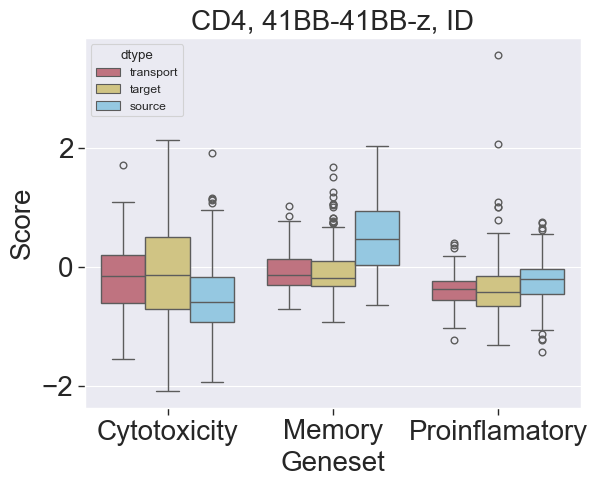

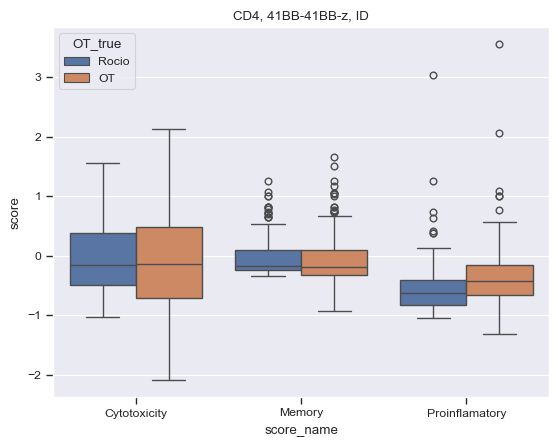

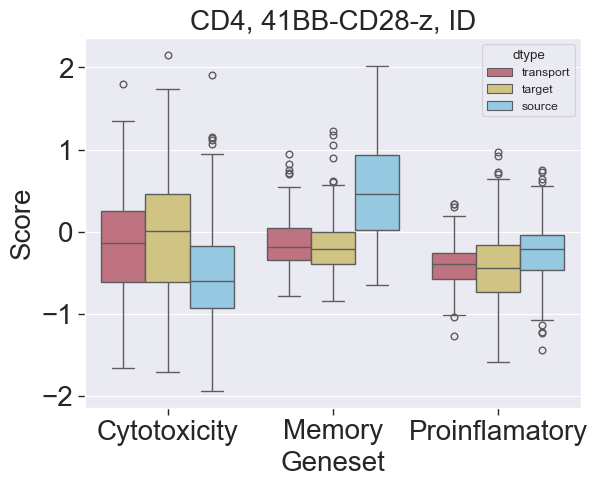

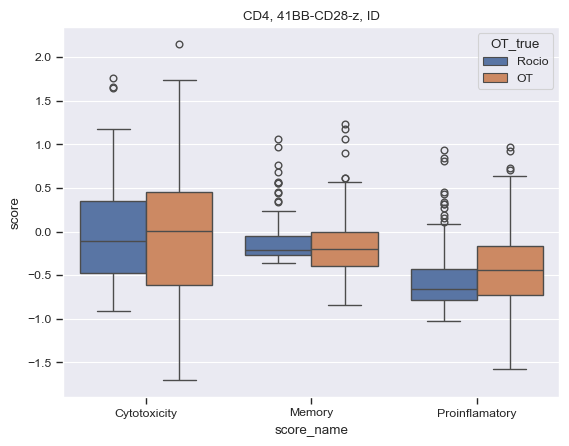

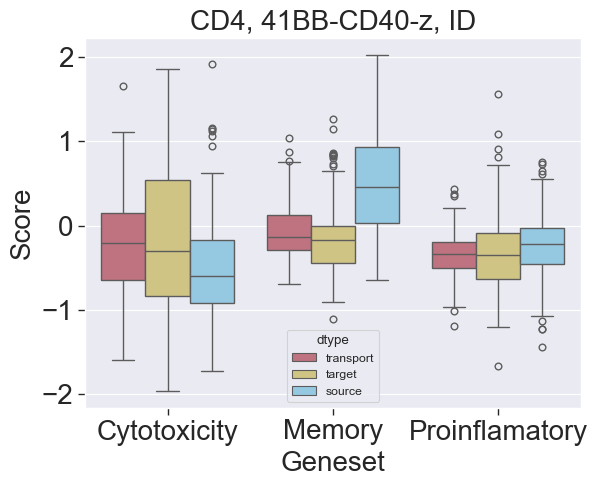

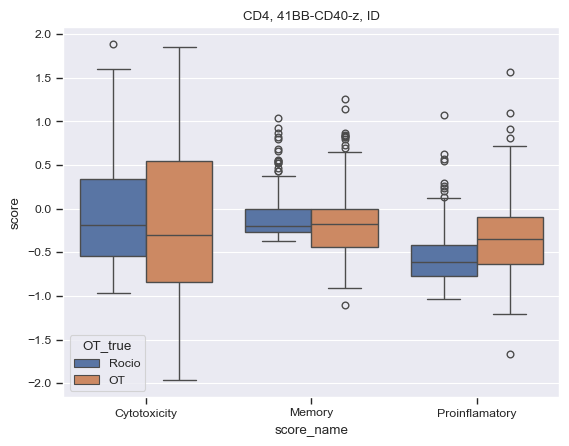

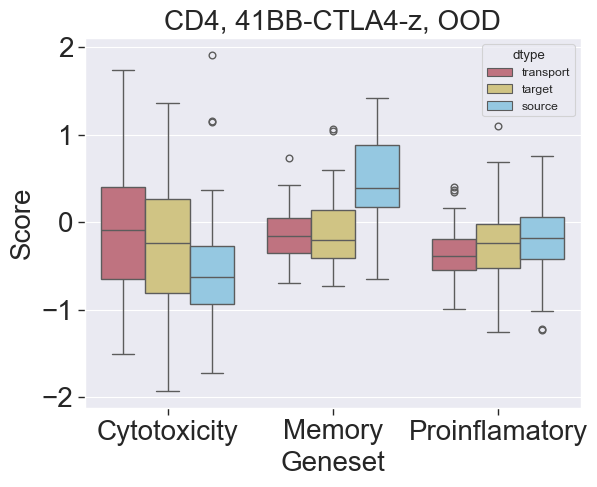

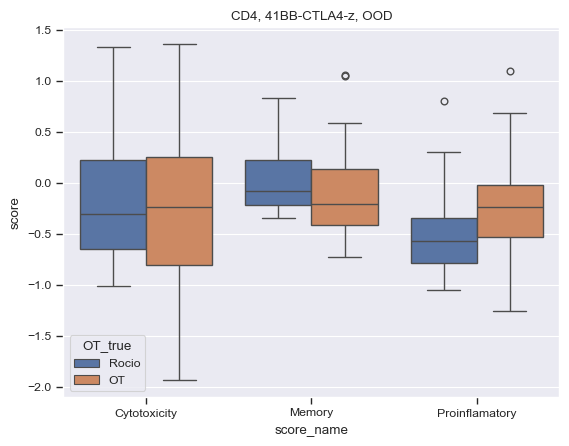

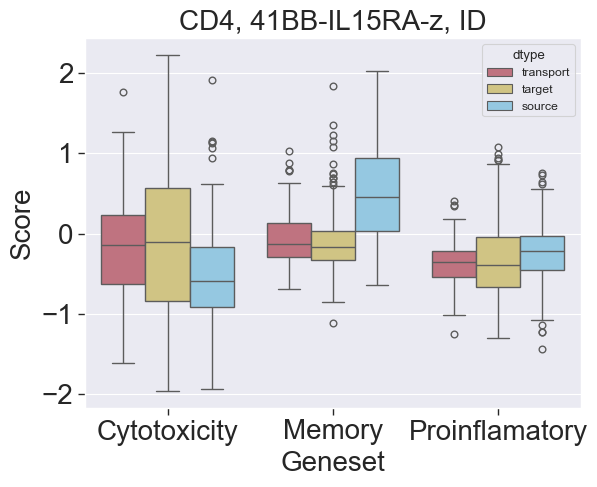

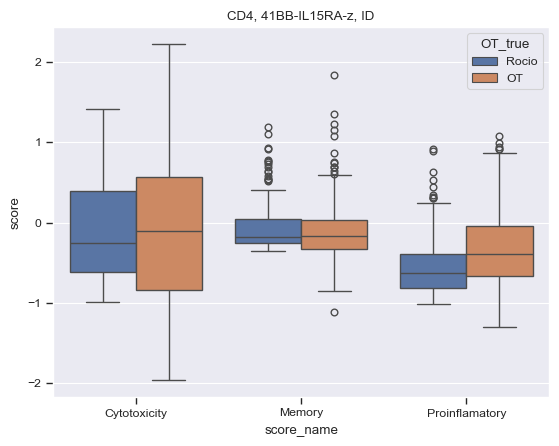

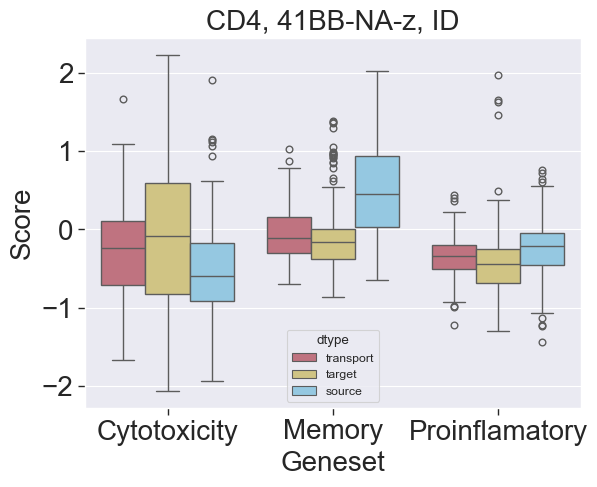

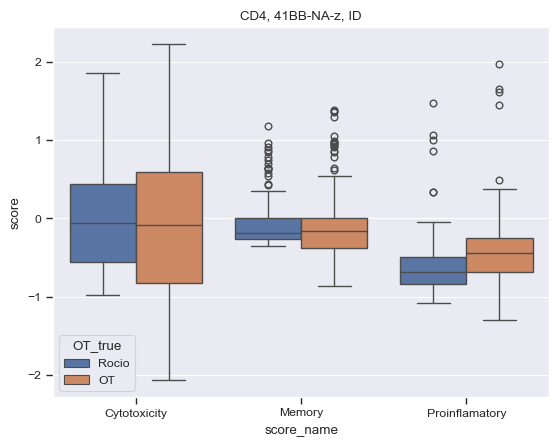

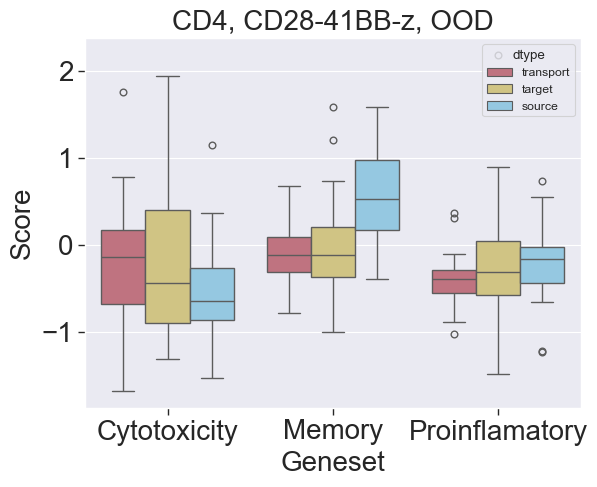

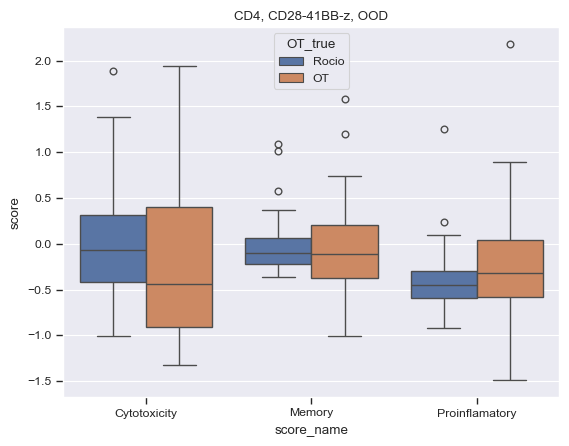

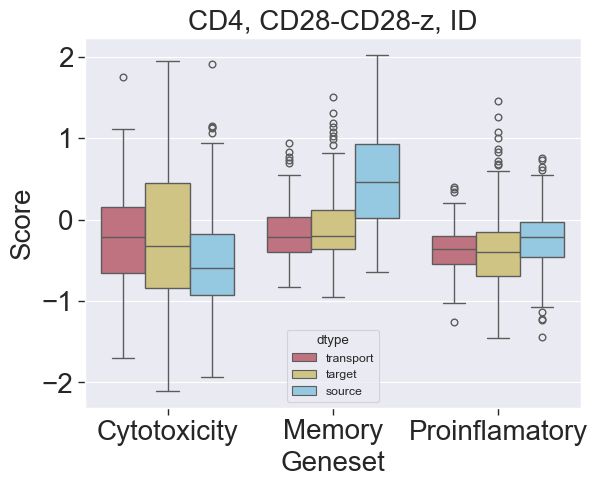

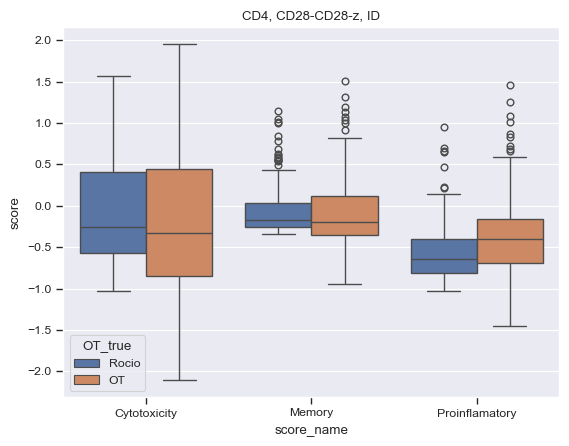

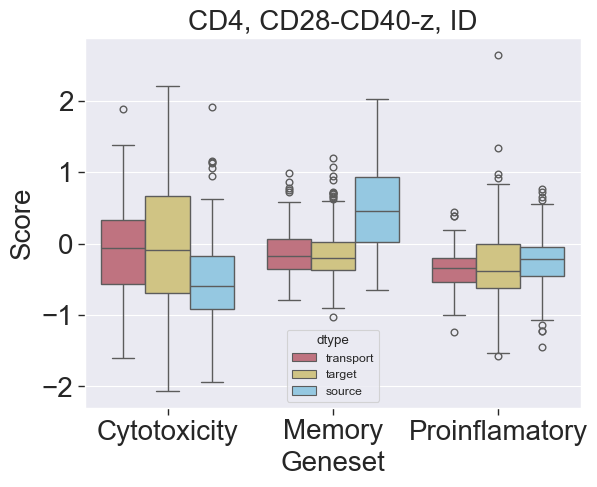

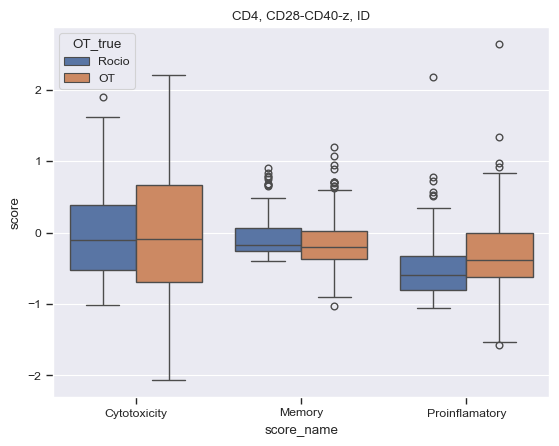

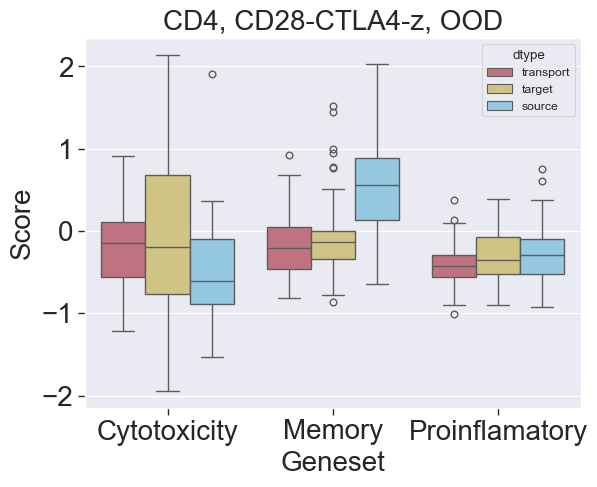

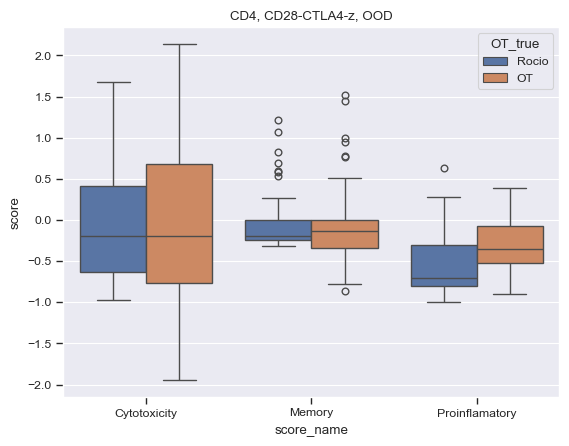

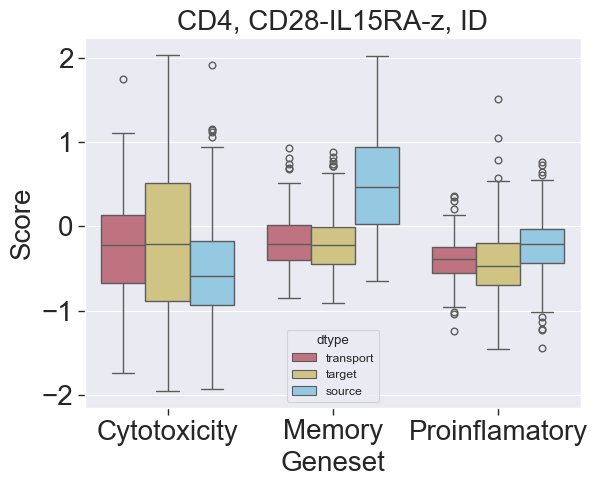

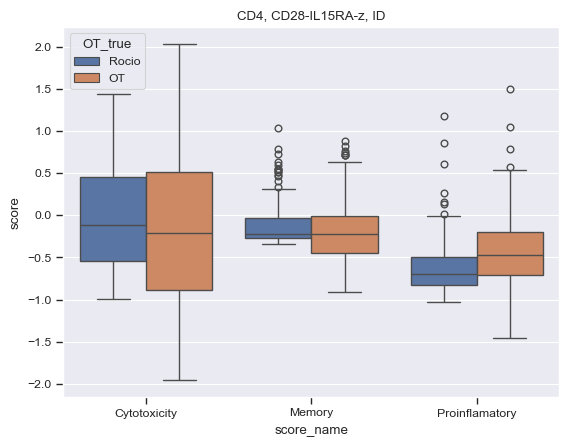

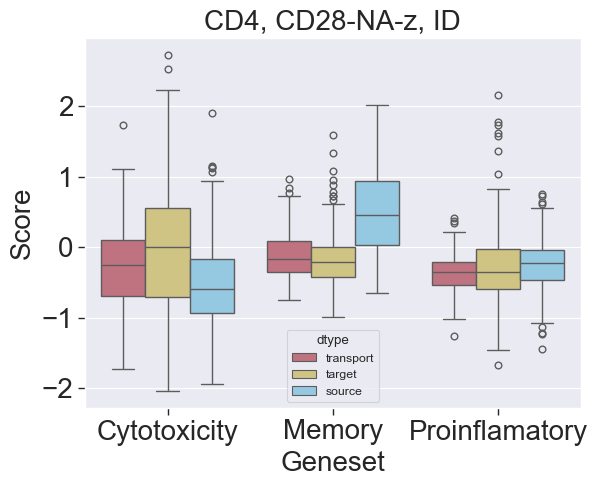

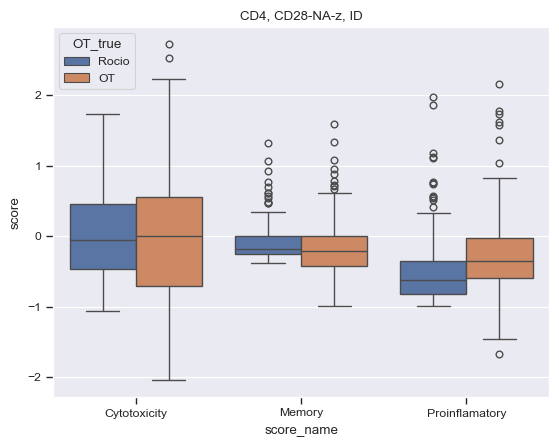

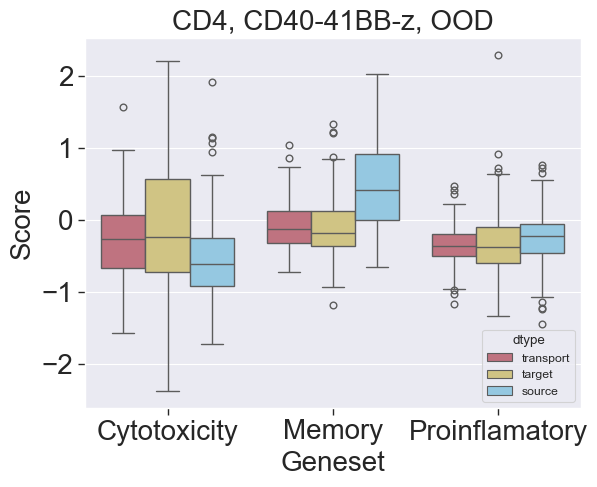

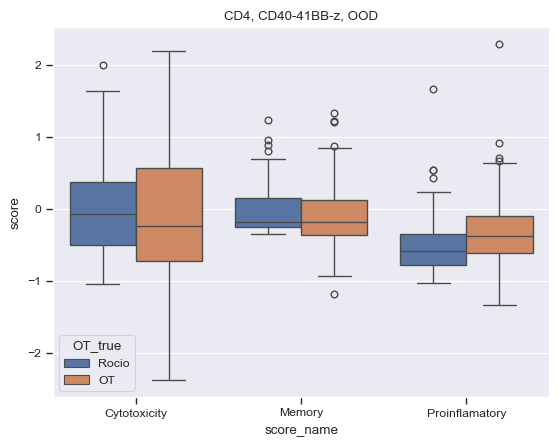

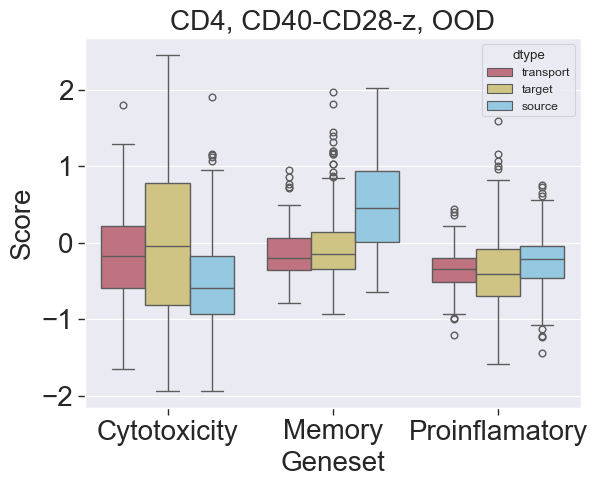

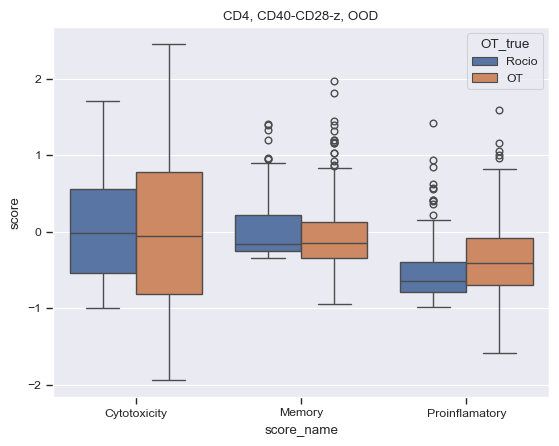

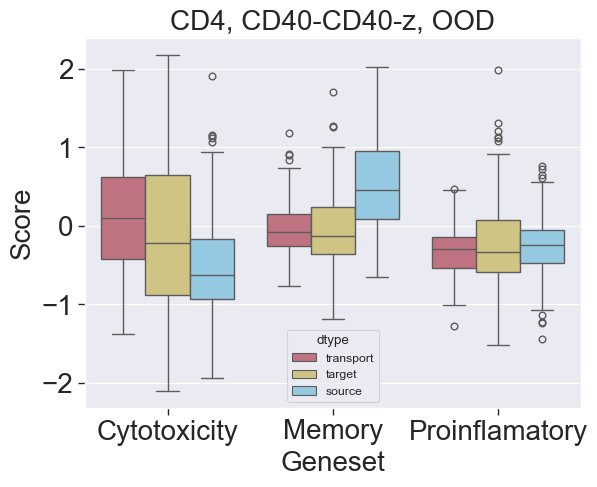

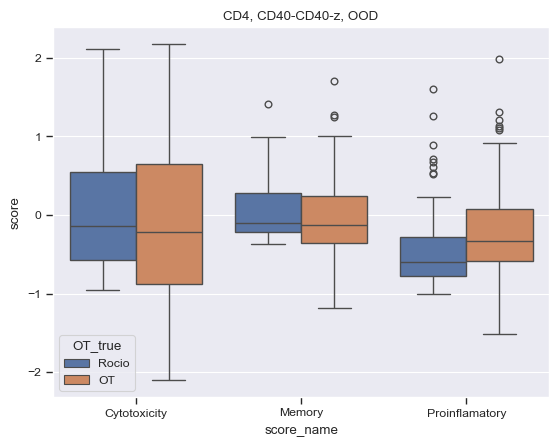

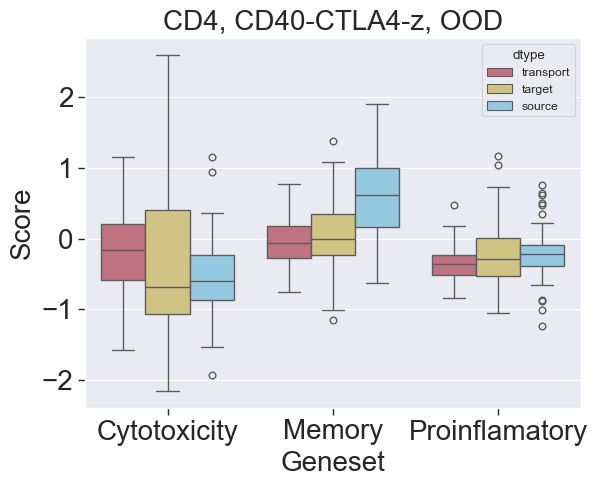

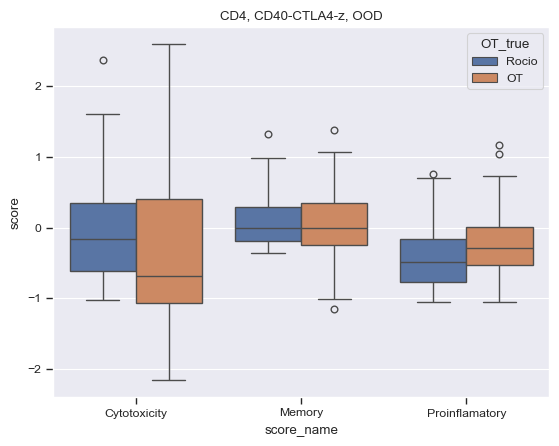

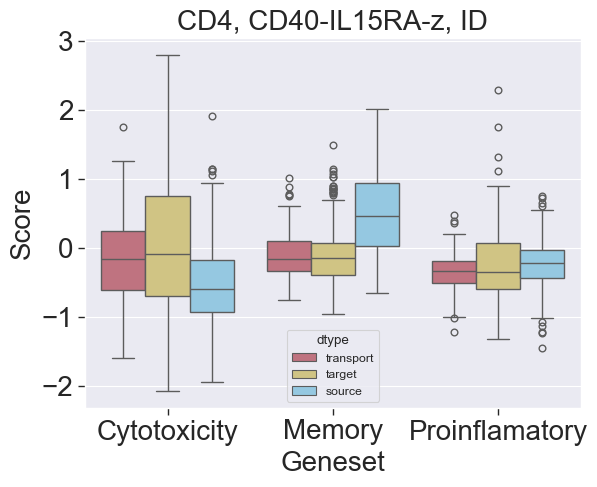

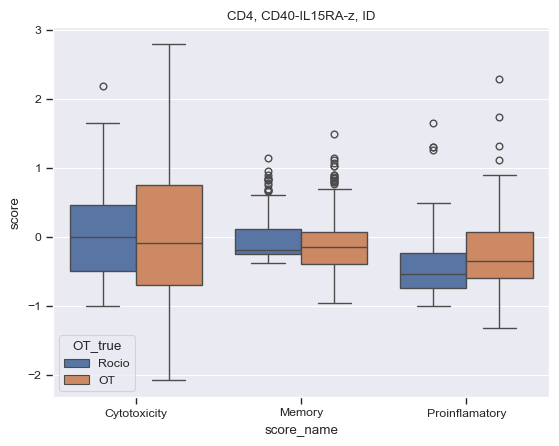

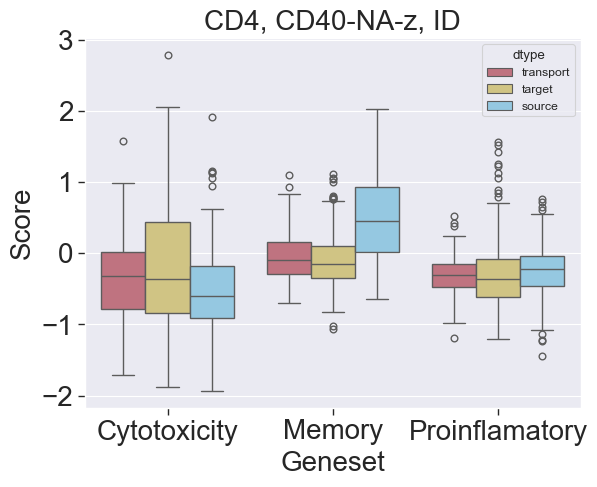

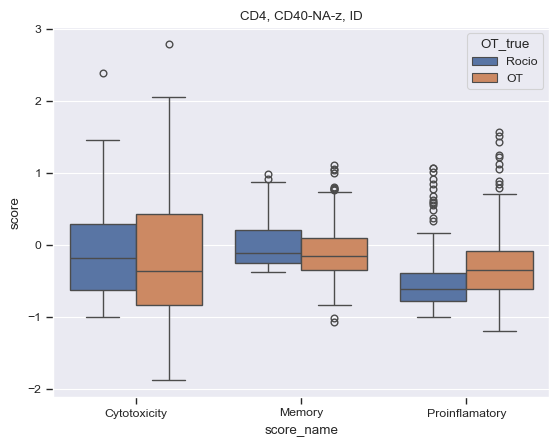

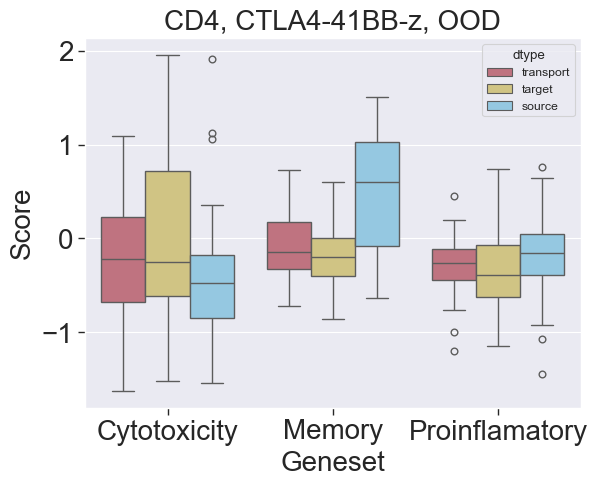

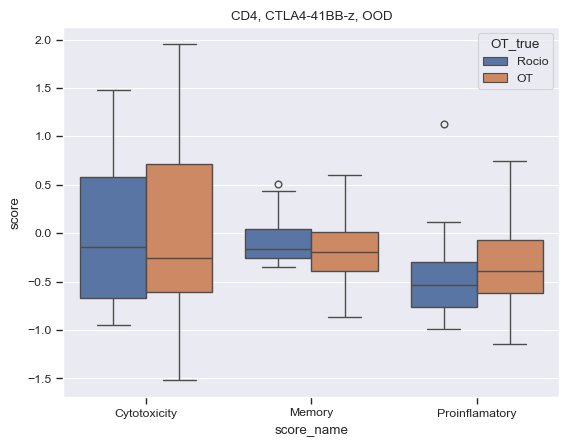

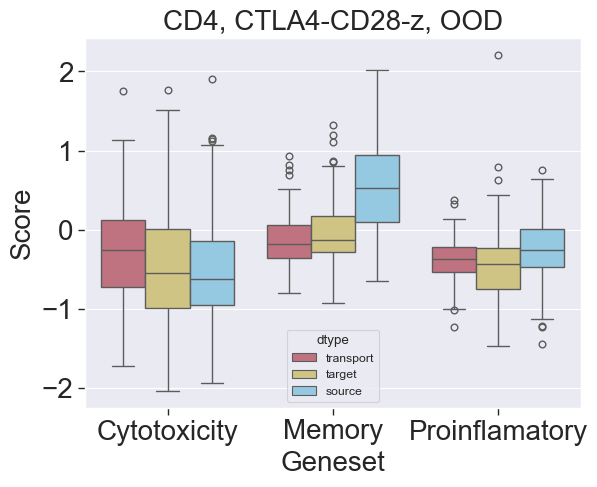

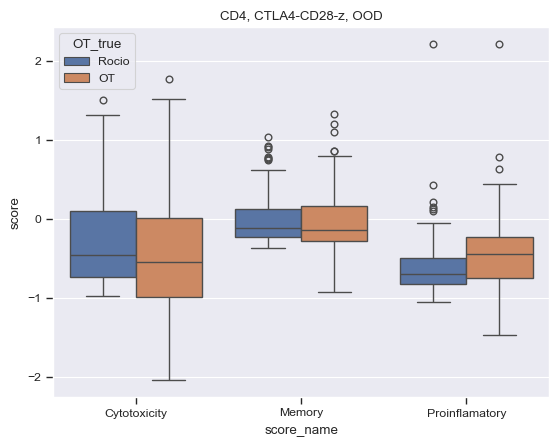

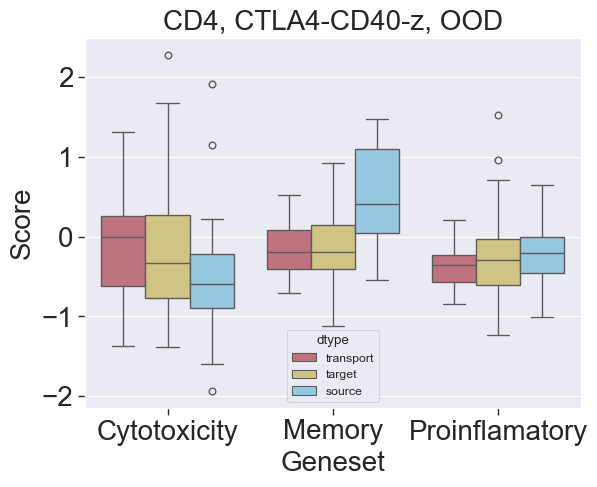

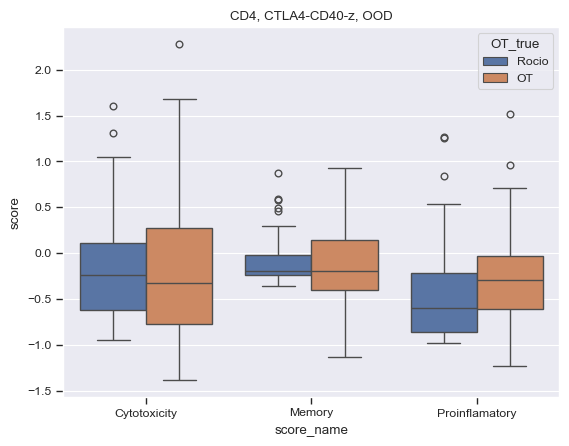

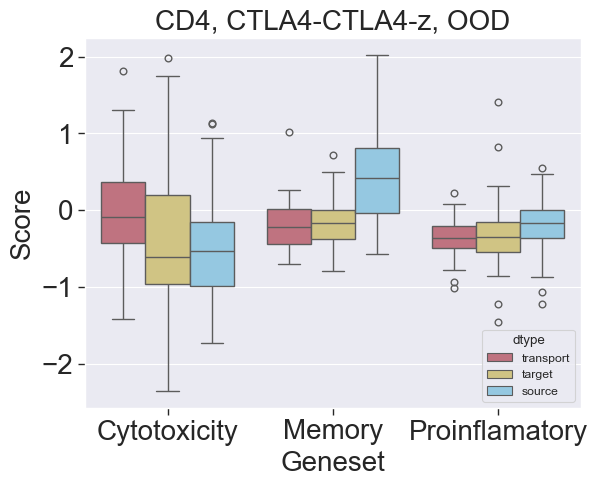

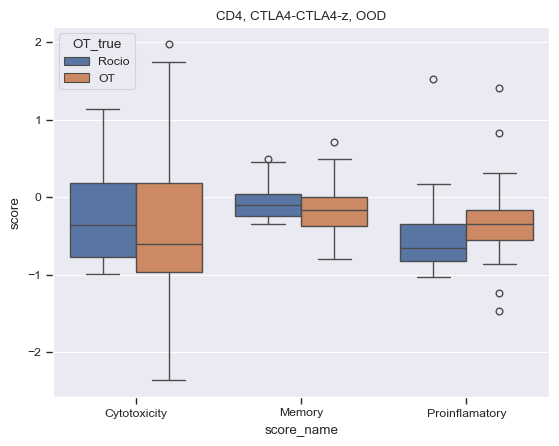

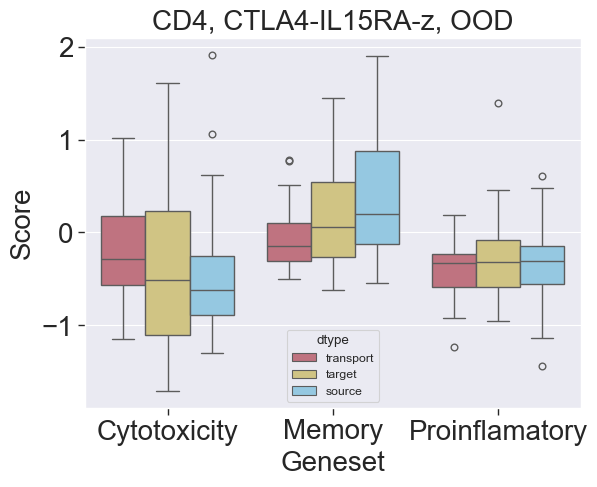

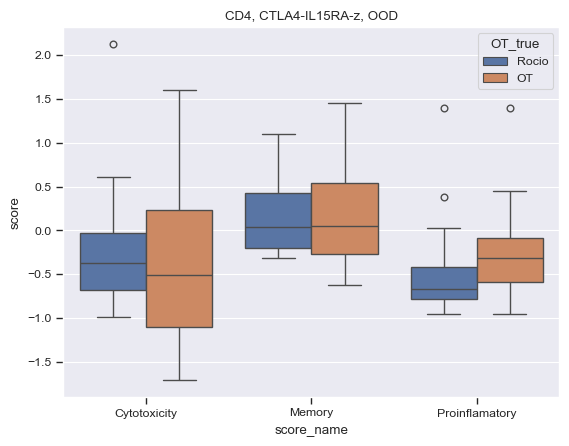

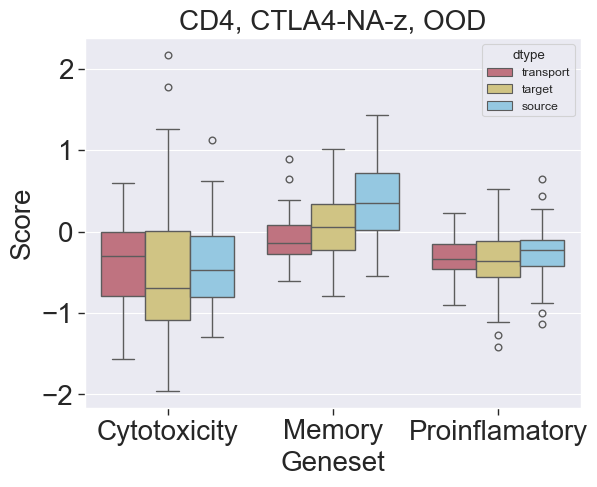

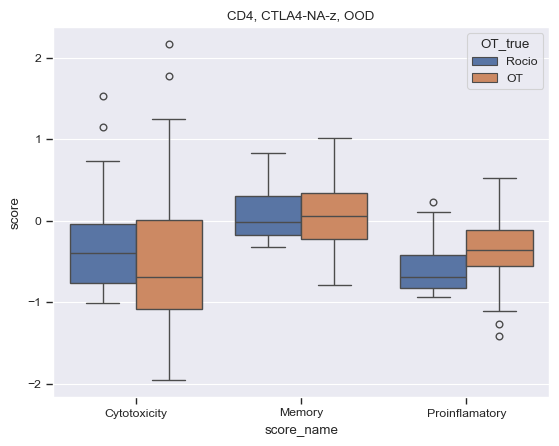

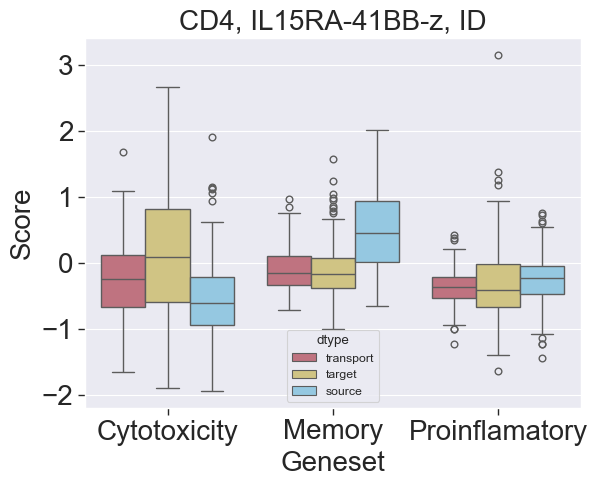

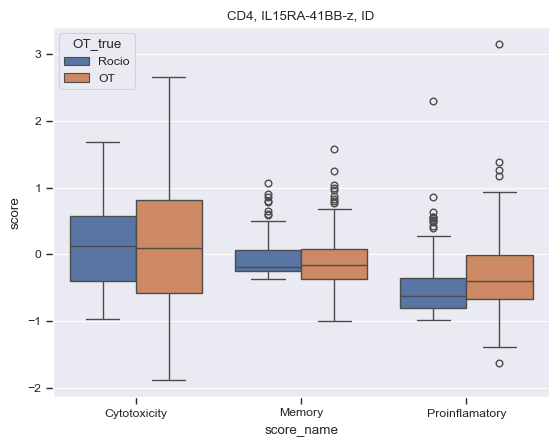

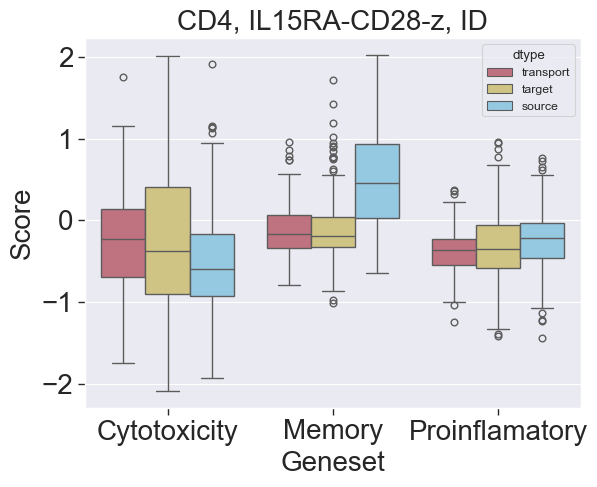

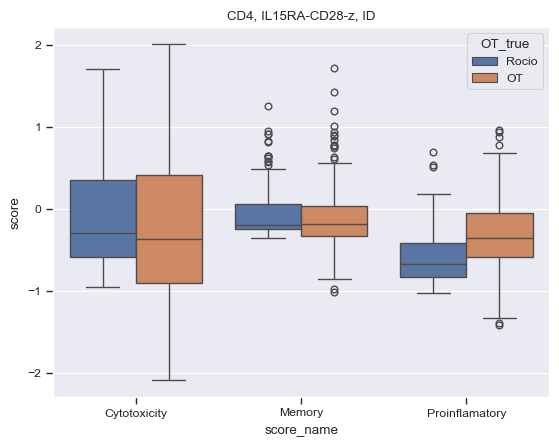

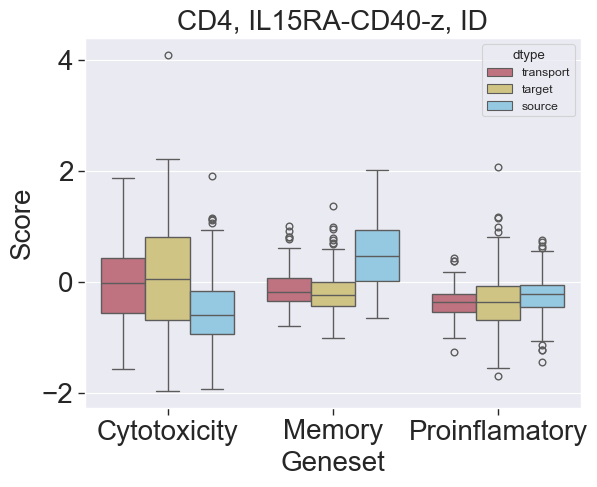

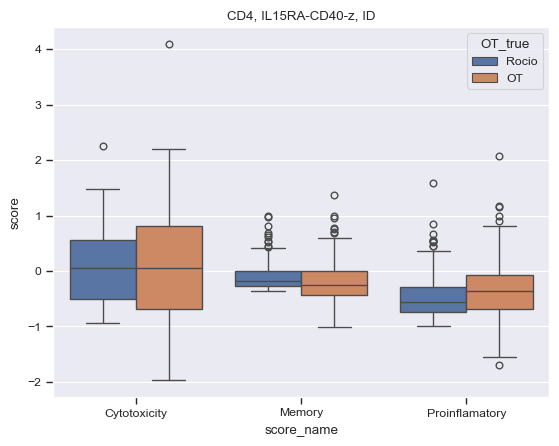

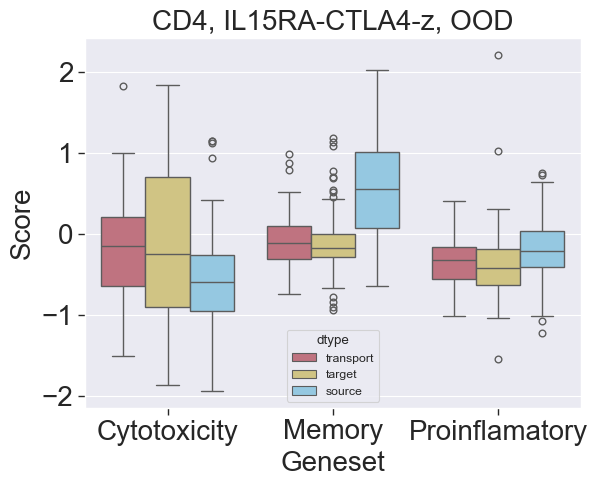

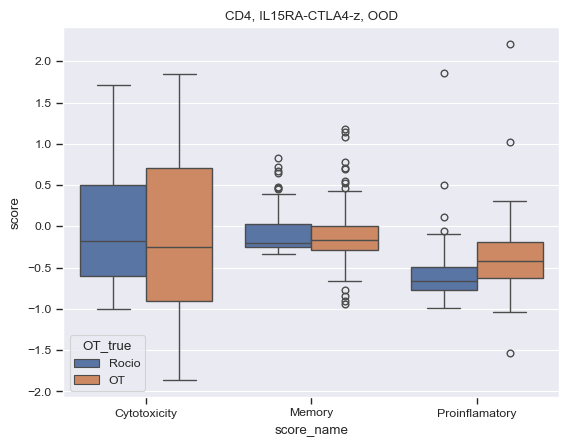

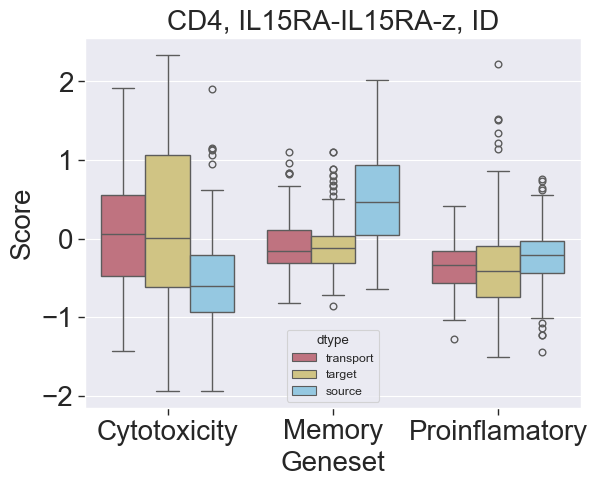

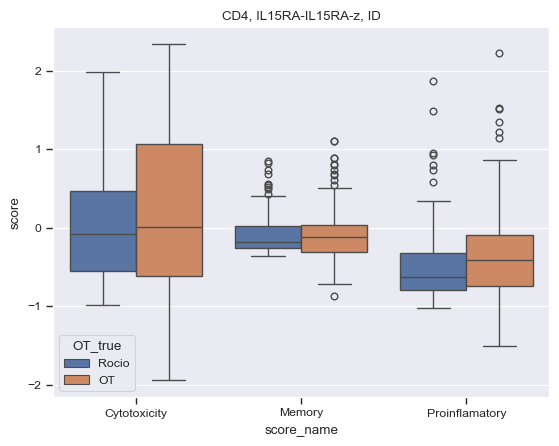

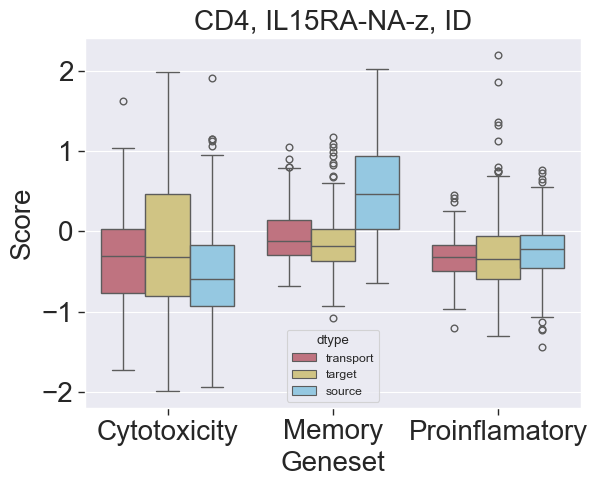

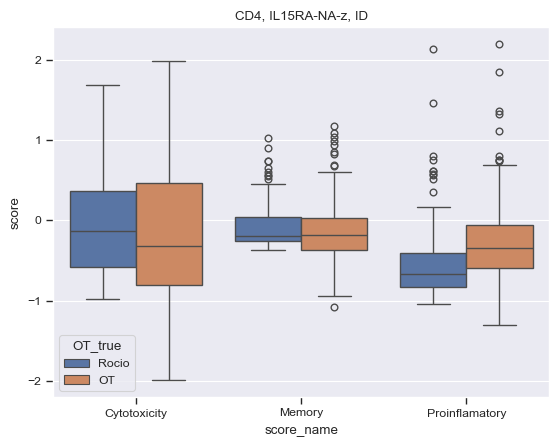

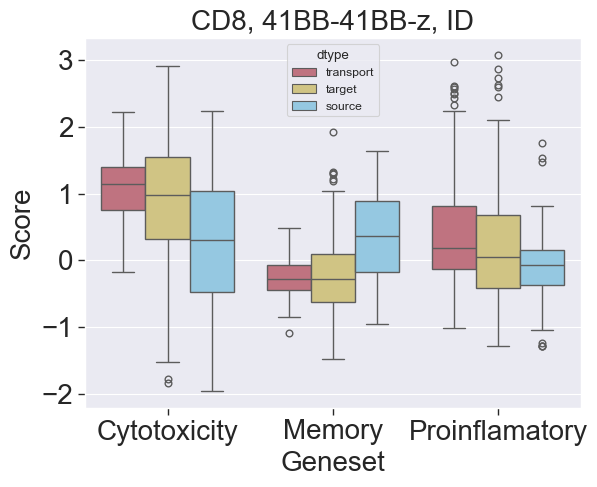

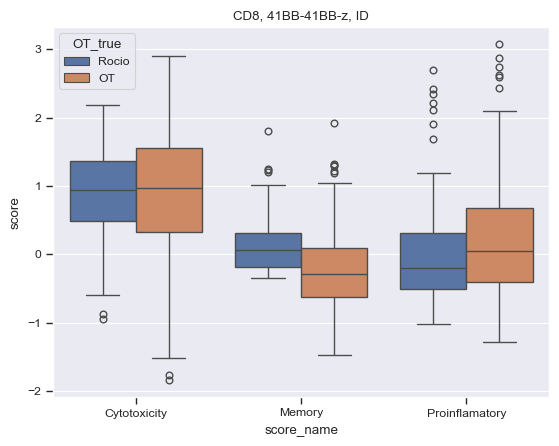

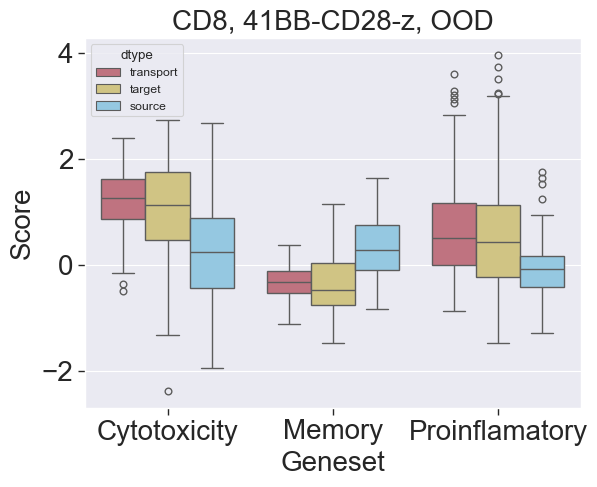

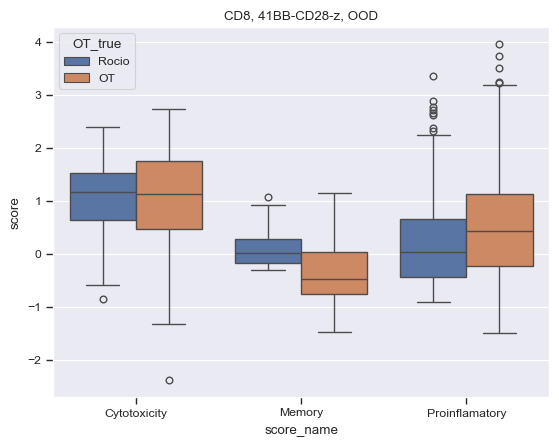

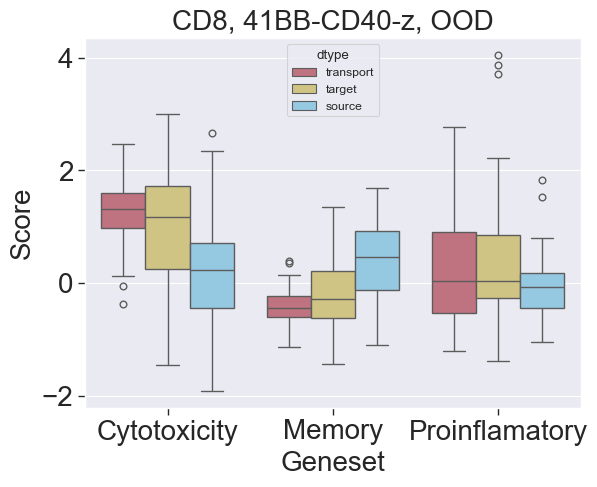

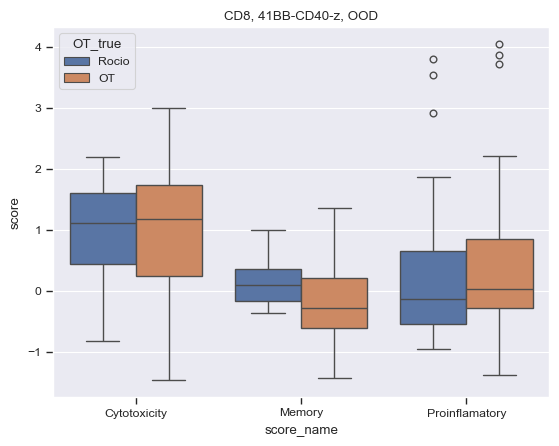

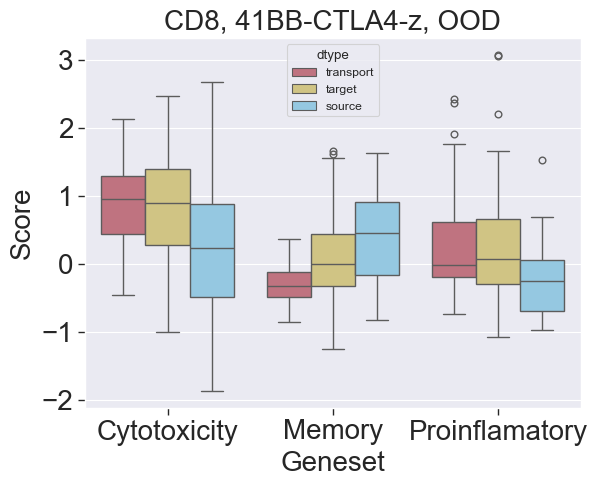

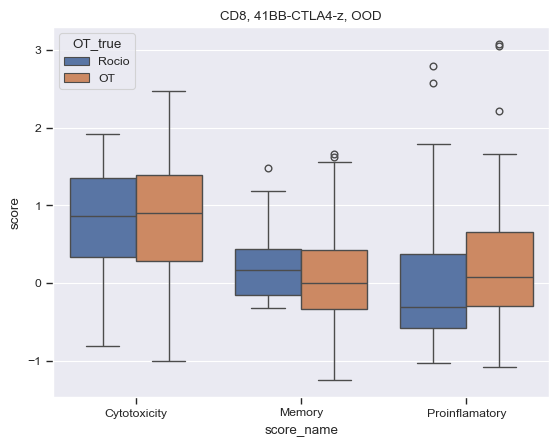

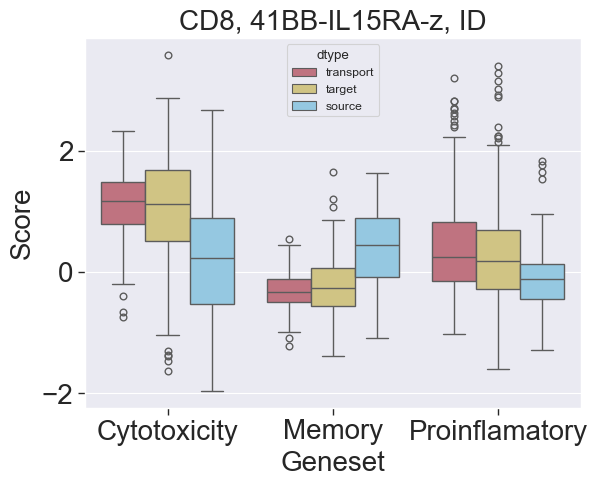

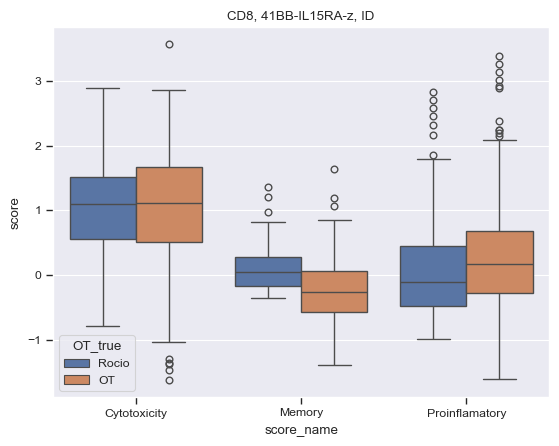

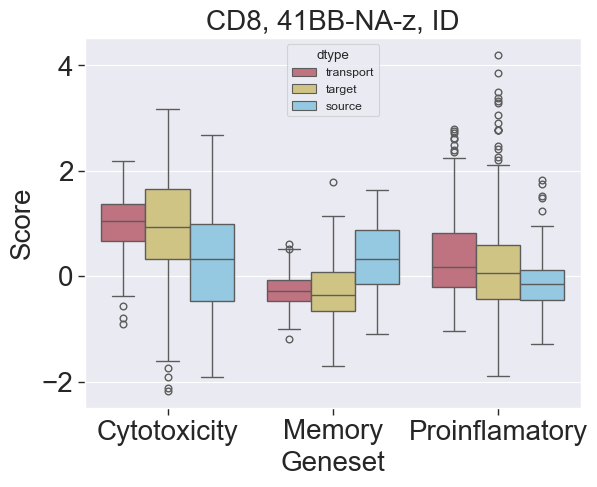

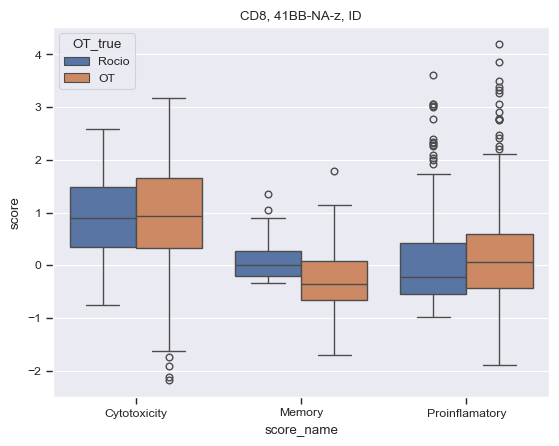

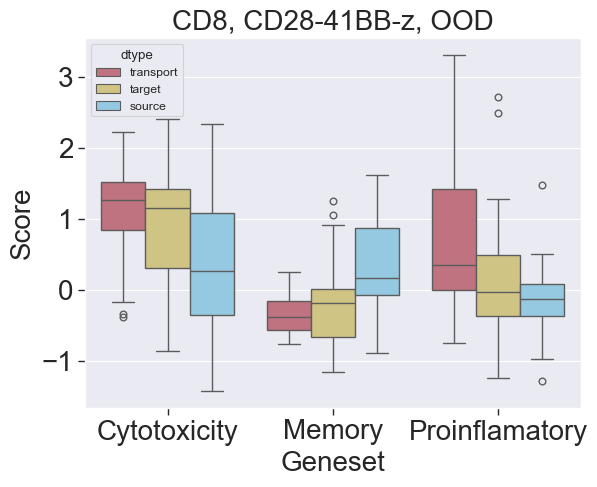

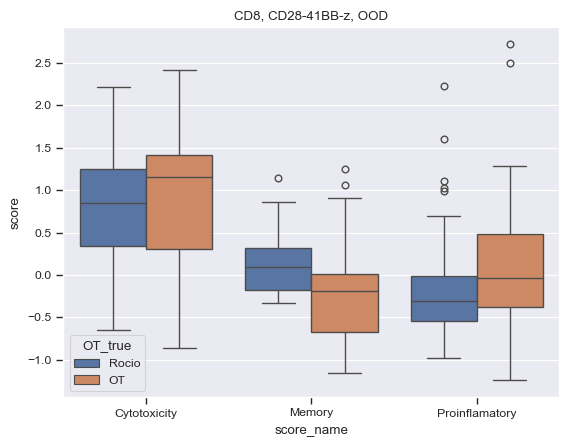

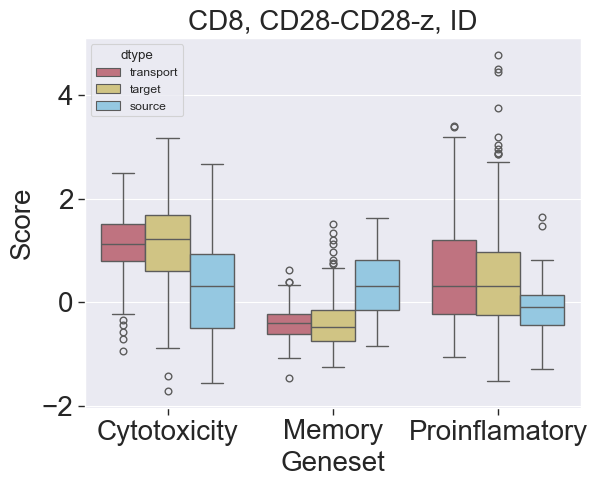

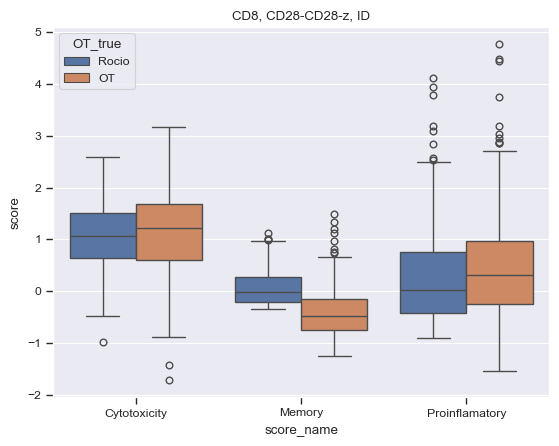

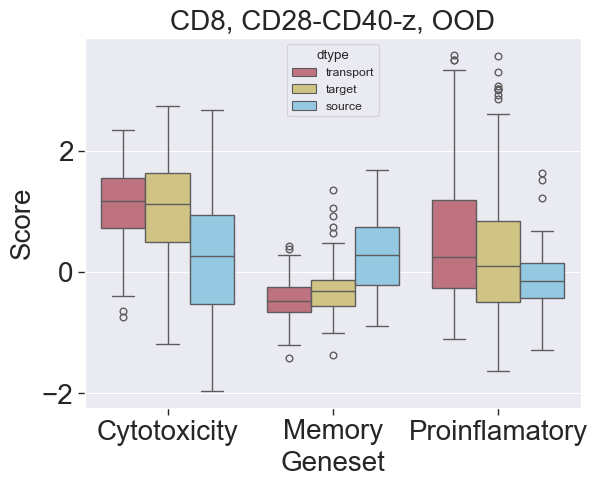

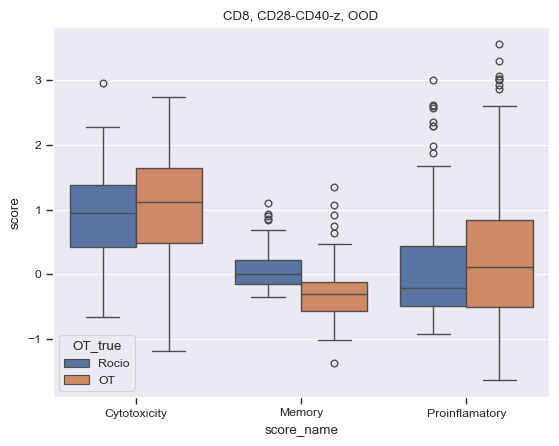

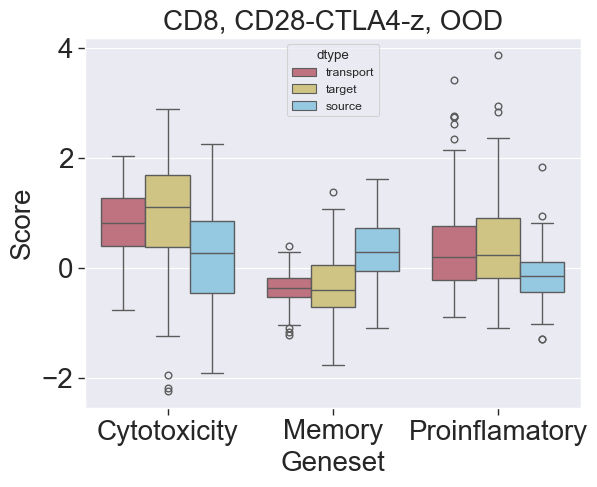

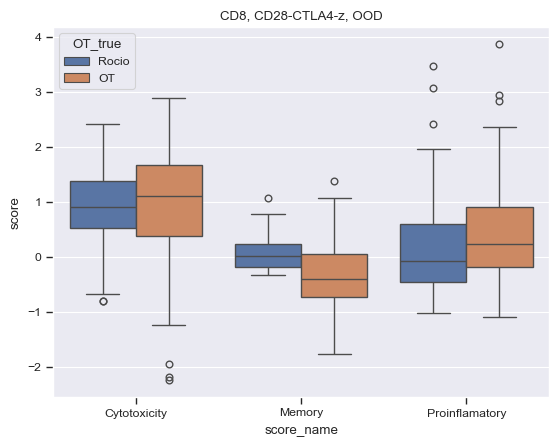

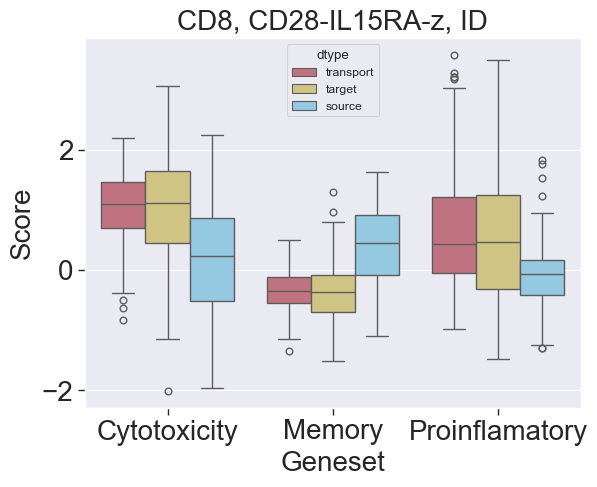

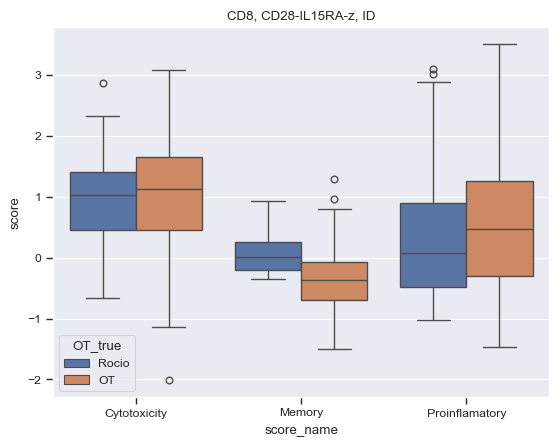

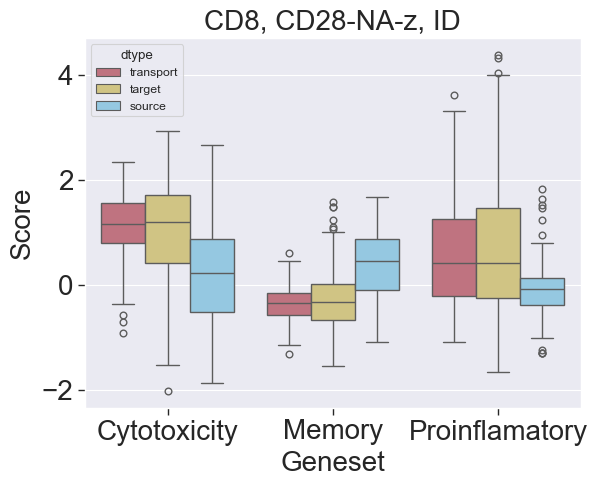

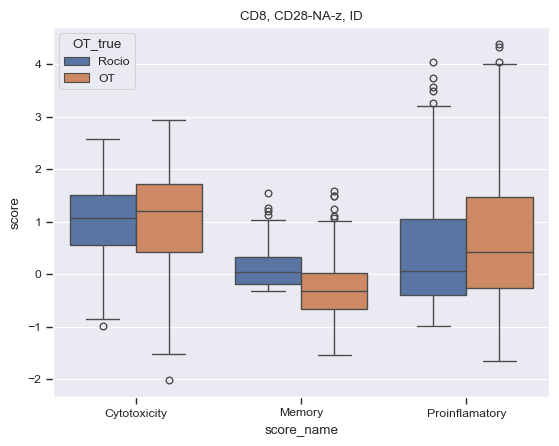

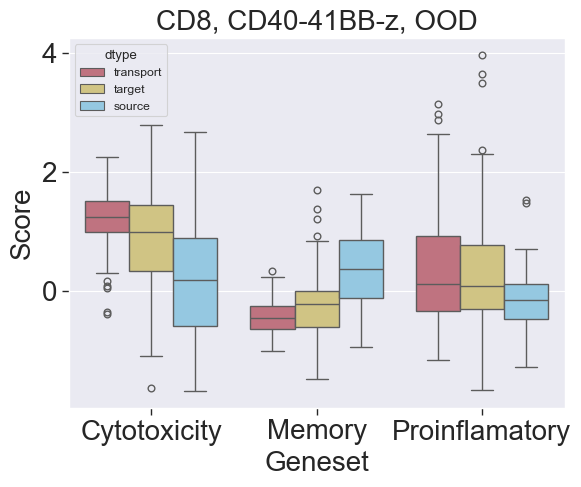

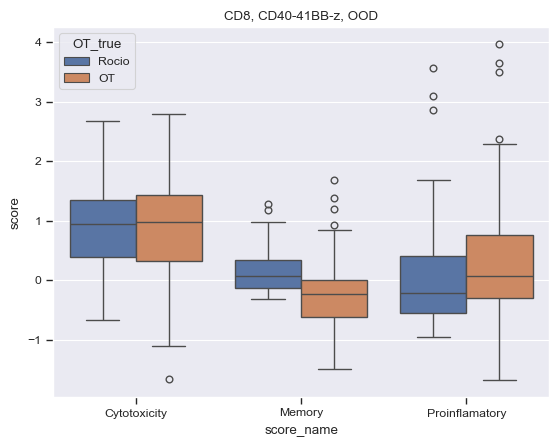

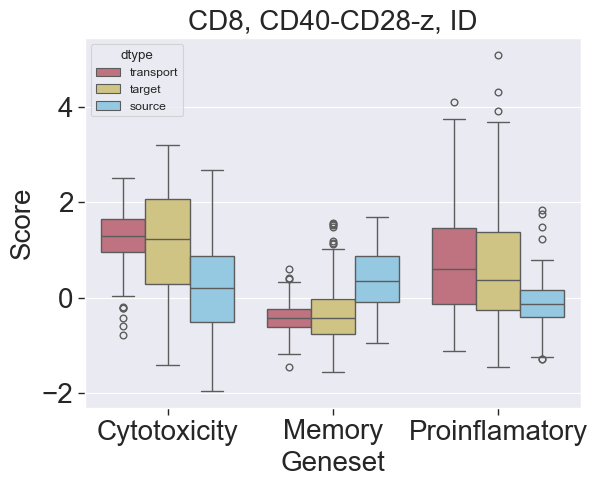

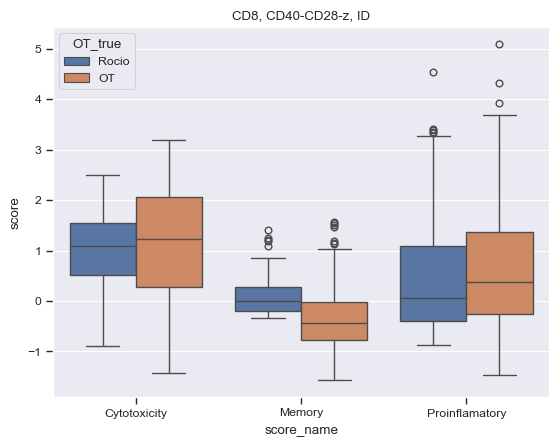

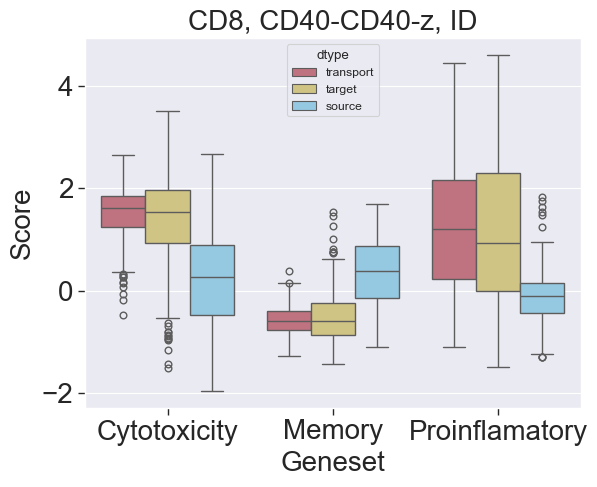

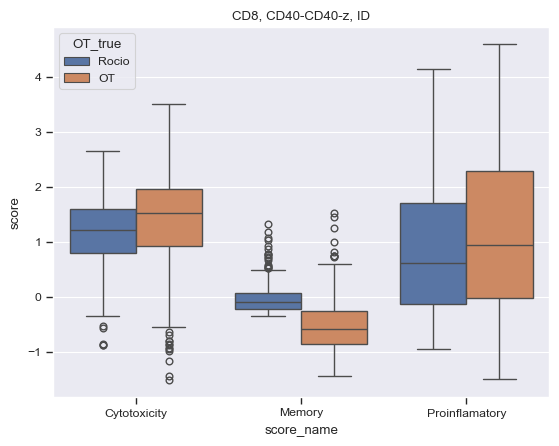

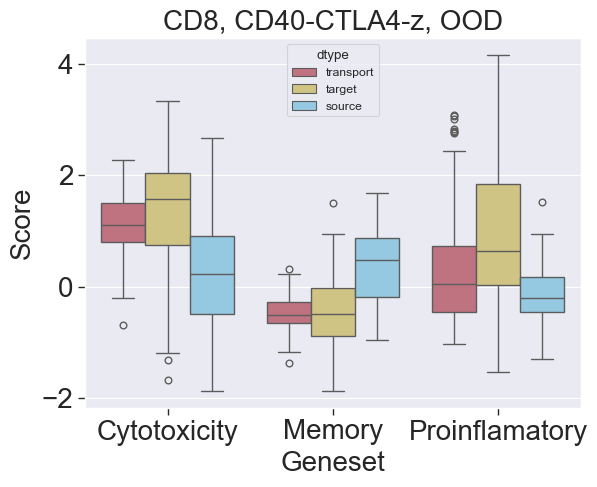

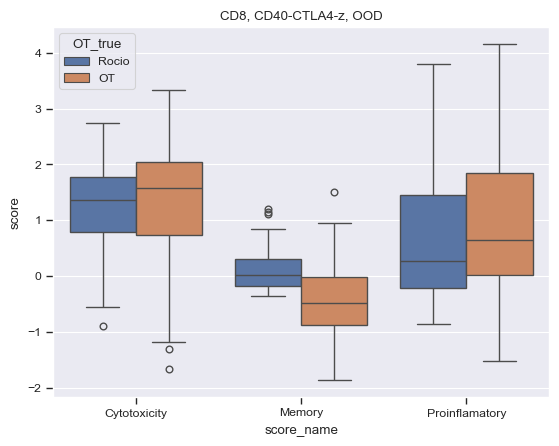

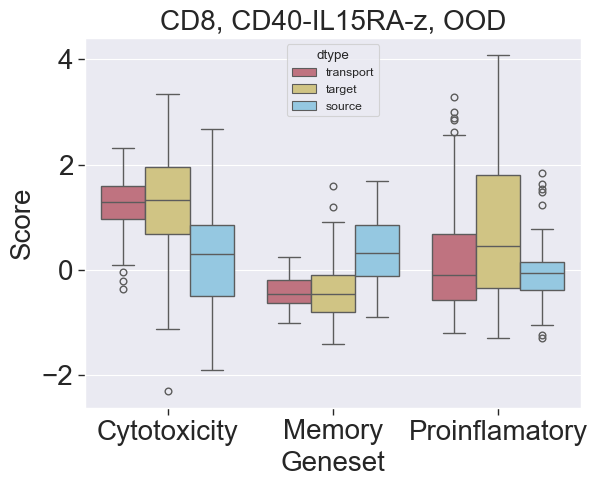

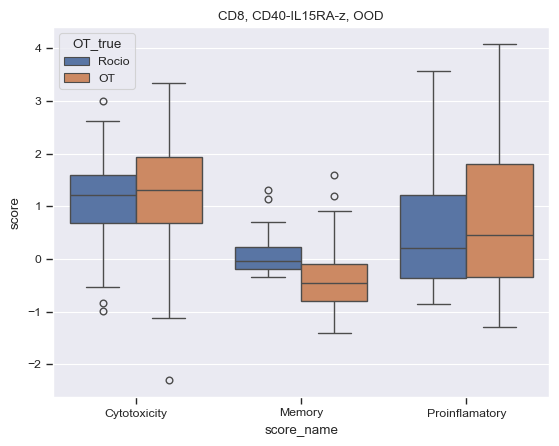

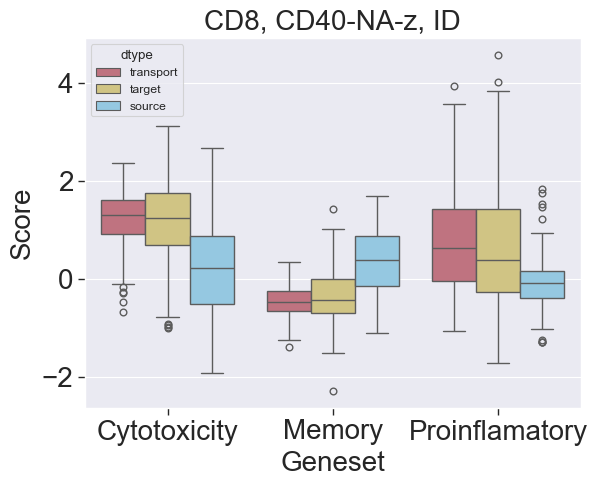

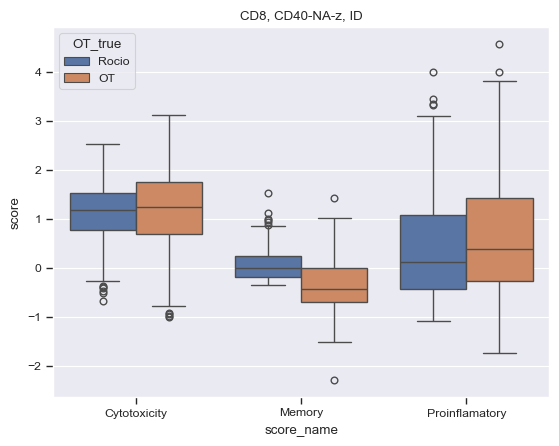

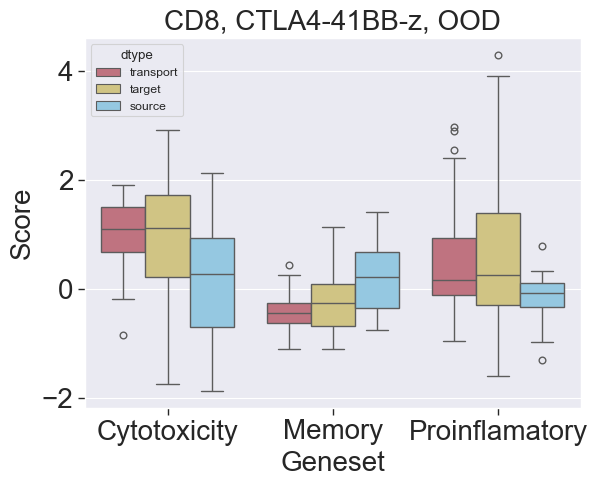

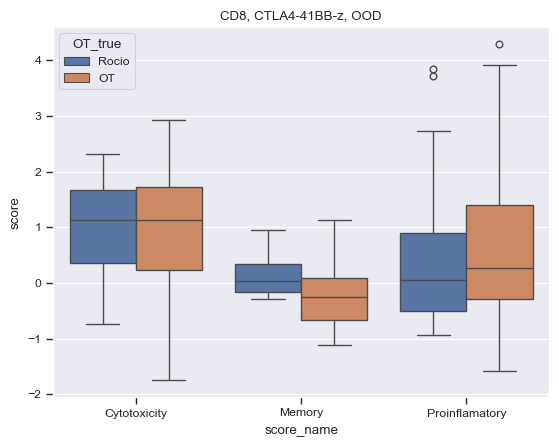

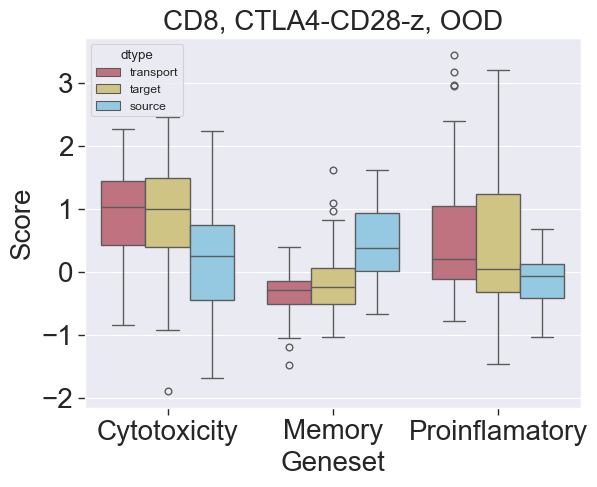

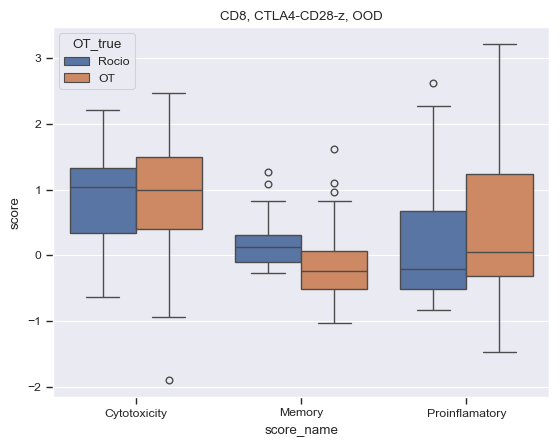

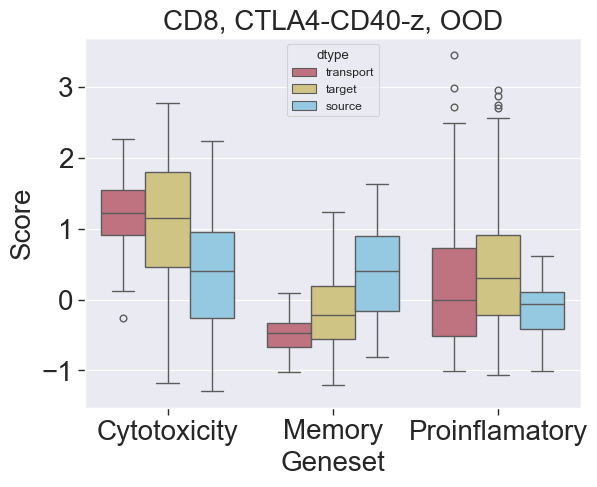

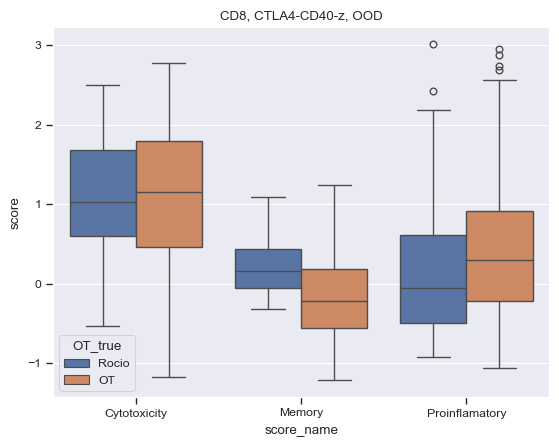

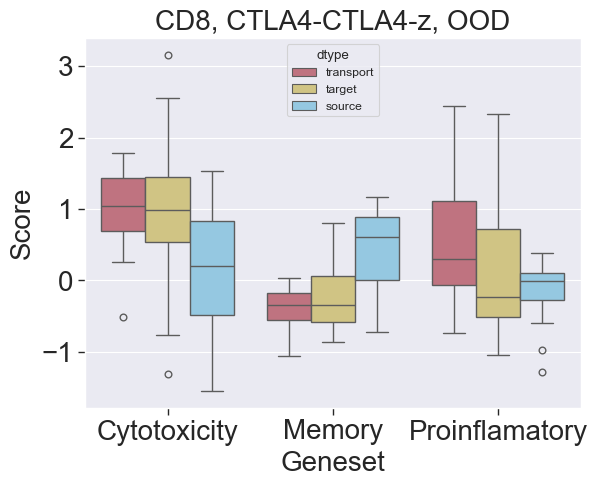

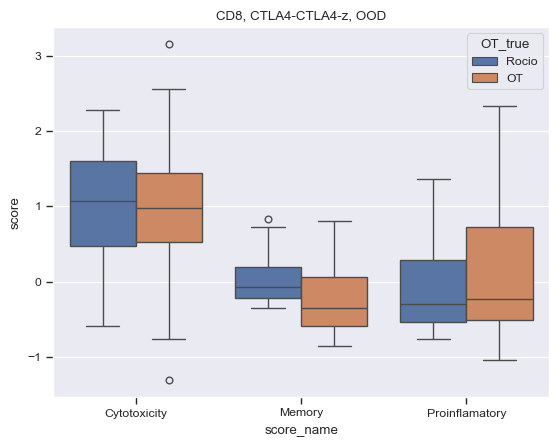

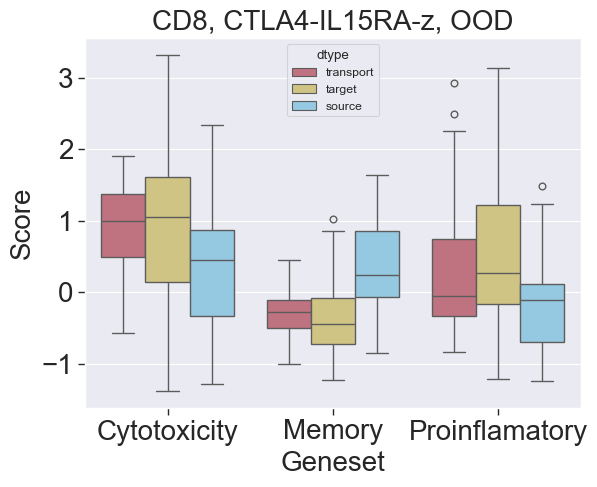

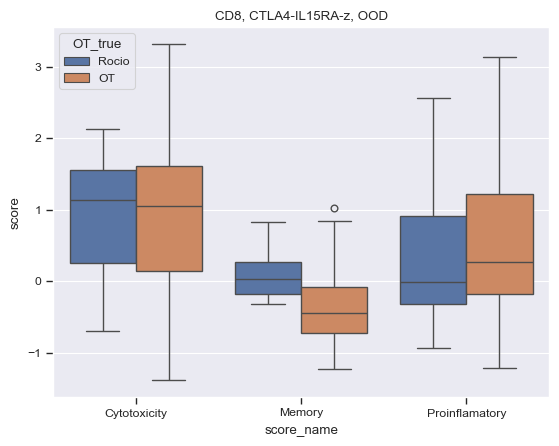

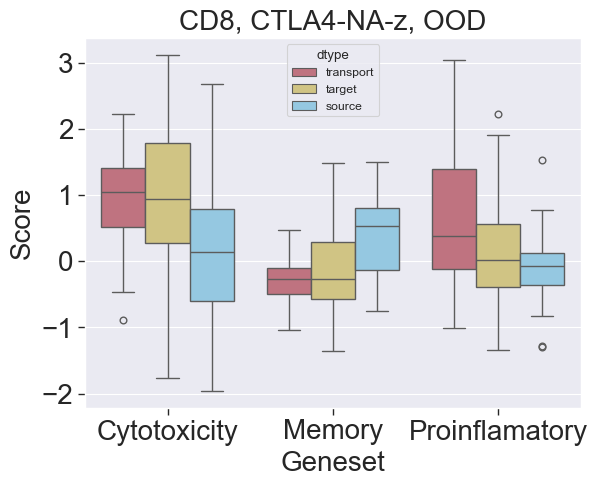

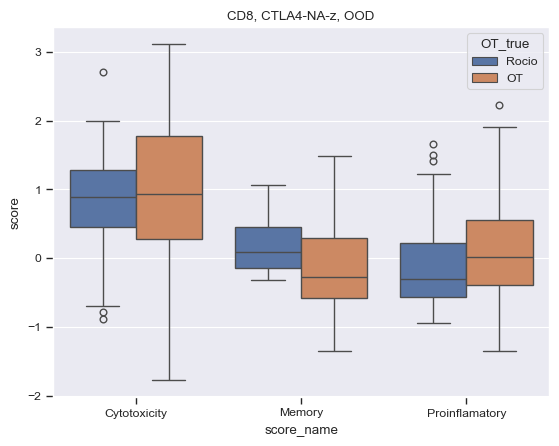

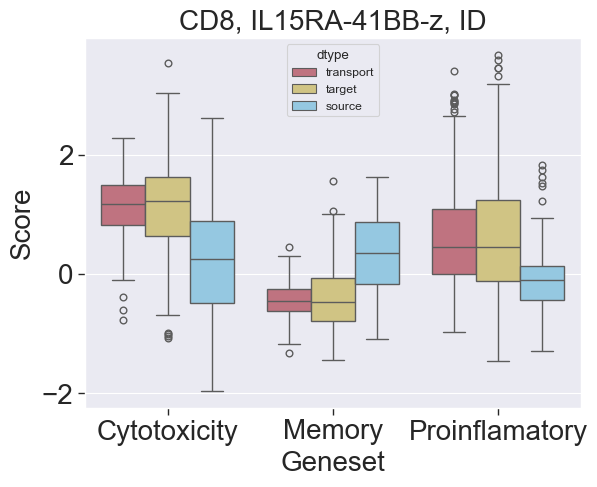

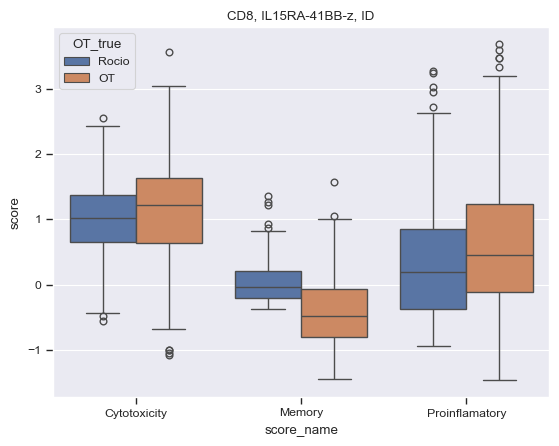

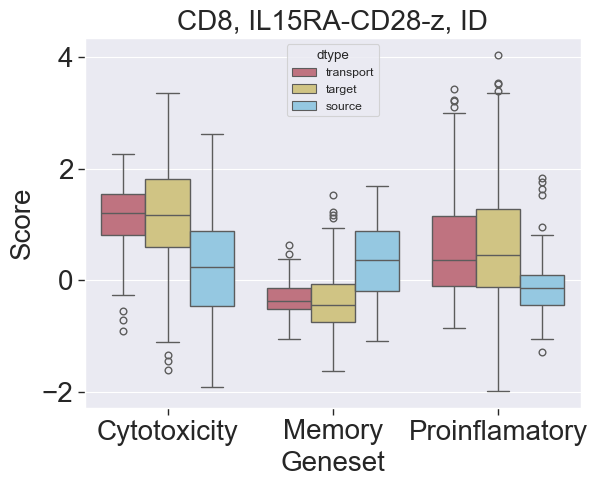

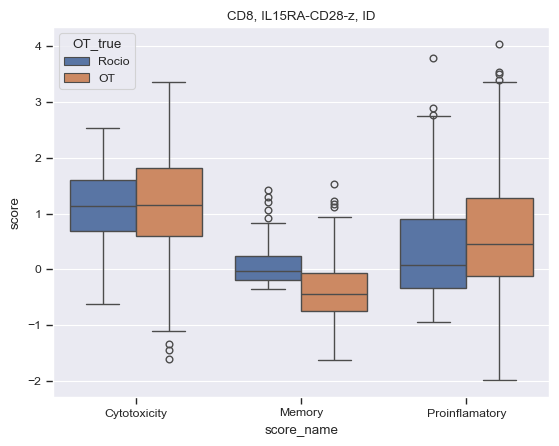

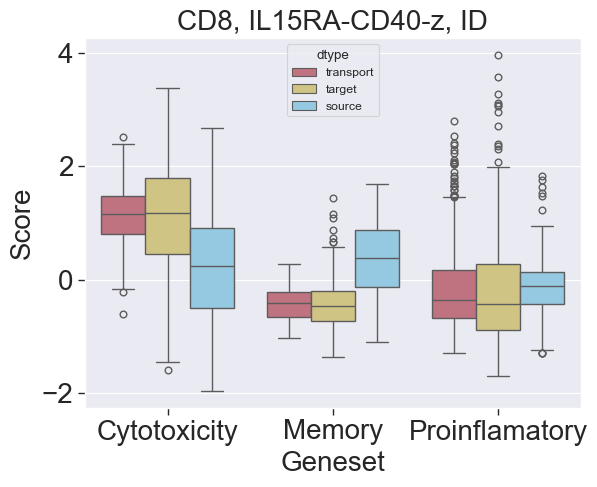

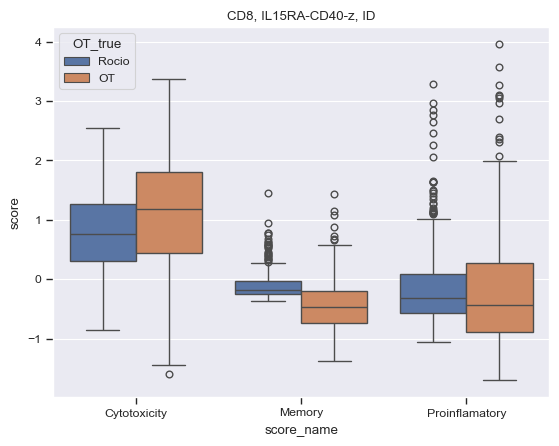

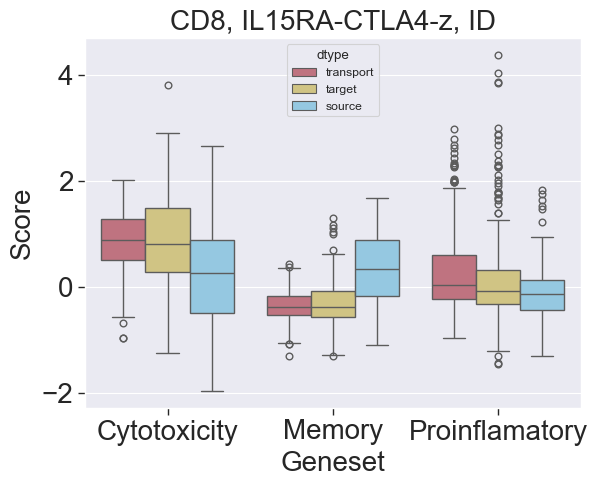

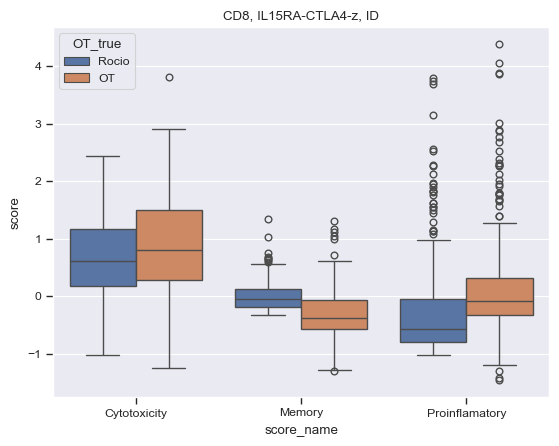

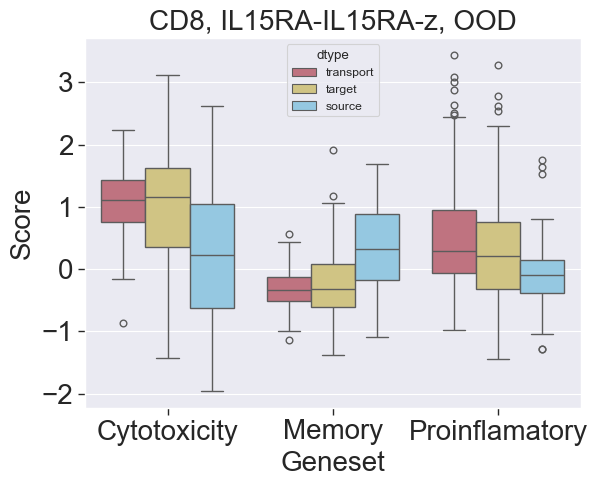

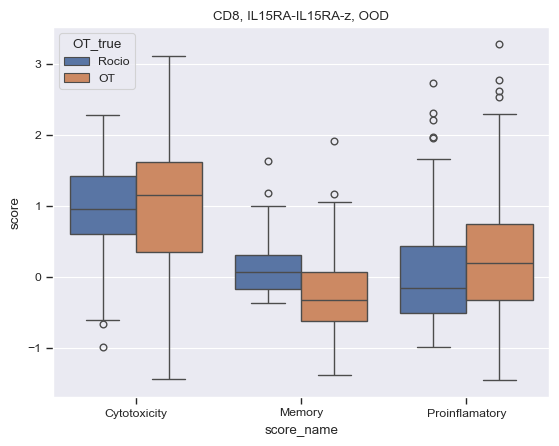

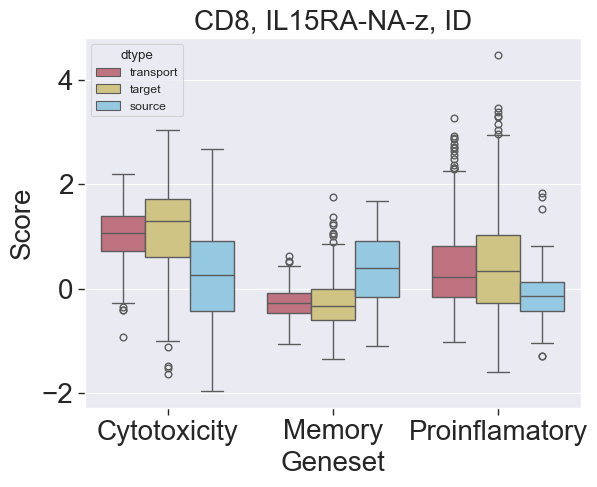

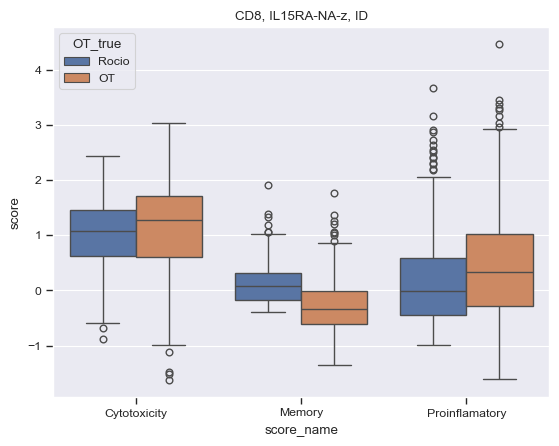

In [14]:
for subset in ["CD4", "CD8"]:
    res = adata[adata.obs["subset"]==subset]
    for car in res.obs["condition"].unique():
        data1 = res[(res.obs["dtype"]=="transport")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflamatory_OT"]]
        data1 = data1.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data1[["score_name", "OT_true"]] = [s.split("_") for s in data1["OT_true"]]
        data1.loc[data1["OT_true"]!="OT", "OT_true"] = "Rocio"
        data1['dtype'] = "transport"
    
        data2 = res[(res.obs["dtype"]=="target")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflamatory_OT"]]
        data2 = data2.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data2[["score_name", "OT_true"]] = [s.split("_") for s in data2["OT_true"]]
        data2.loc[data2["OT_true"]!="OT", "OT_true"] = "Rocio"
        data2['dtype'] = "target"
    
        data3 = res[(res.obs["dtype"]=="source")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflamatory_OT"]]
        data3 = data3.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data3[["score_name", "OT_true"]] = [s.split("_") for s in data3["OT_true"]]
        data3.loc[data3["OT_true"]!="OT", "OT_true"] = "Rocio"
        data3['dtype'] = "source"
    
        data1.loc[data1["OT_true"]=="true", "score"] = data2.loc[data2["OT_true"]=="true", "score"].values
        data=pd.concat([data1, data2, data3])
        data["CAR_Variant"] = car
        data["subset"] = subset
        
        sns.boxplot(data=data[data["OT_true"]=="OT"], x="score_name", y="score", hue="dtype", palette=ot_map, hue_order=["transport", "target", "source"])
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}", fontsize=20)
        plt.xlabel("Geneset", fontsize=20)
        plt.ylabel("Score", fontsize=20)
        plt.tick_params(which="both", axis="both", labelsize=20)
        plt.savefig(f"{base_fig_save}{subset}_{car}_score_comparison_box.pdf", bbox_inches="tight")
        plt.show()

        sns.boxplot(data=data[data["dtype"]=="target"], x="score_name", y="score", hue="OT_true")
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}")
        plt.show()



# Threshold determination

In [15]:
all_adata = sc.read_h5ad(f"{data_path}20240229_from_rocio_for_manuscript.h5ad")
all_adata.X = all_adata.layers["logcounts"]
sc.tl.score_genes(all_adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(all_adata, genesets["Proinflamatory"], score_name="Proinflamatory_OT")
sc.tl.score_genes(all_adata, genesets["Memory"], score_name="Memory_OT")

In [16]:
all_adata

AnnData object with n_obs × n_vars = 58949 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'CAR_Variant', 'Donor', 'Time', 'Lane', 'Sample', 'percent.mt', 'A', 'B', 'C', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.75', 'seurat_clusters', 'subset_RNA', 'subset_ADT', 'subset', 'Cytotoxicity_1', 'Proinflamatory_2', 'Memory_3', 'CD4_Th1_4', 'CD4_Th2_5', 'ident', 'Cytotoxicity_OT', 'Proinflamatory_OT', 'Memory_OT'
    obsm: 'HARMONY', 'X_pca', 'X_umap'
    layers: 'logcounts'

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has b

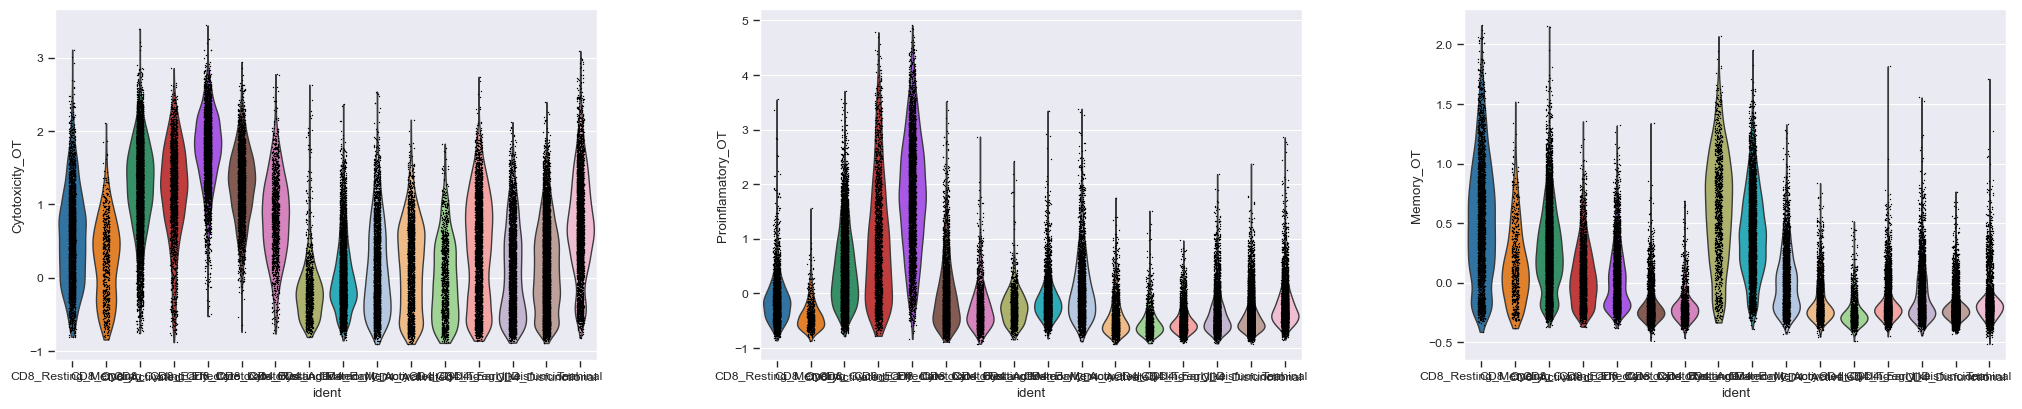

In [17]:
g=sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflamatory_OT", "Memory_OT"])


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has b

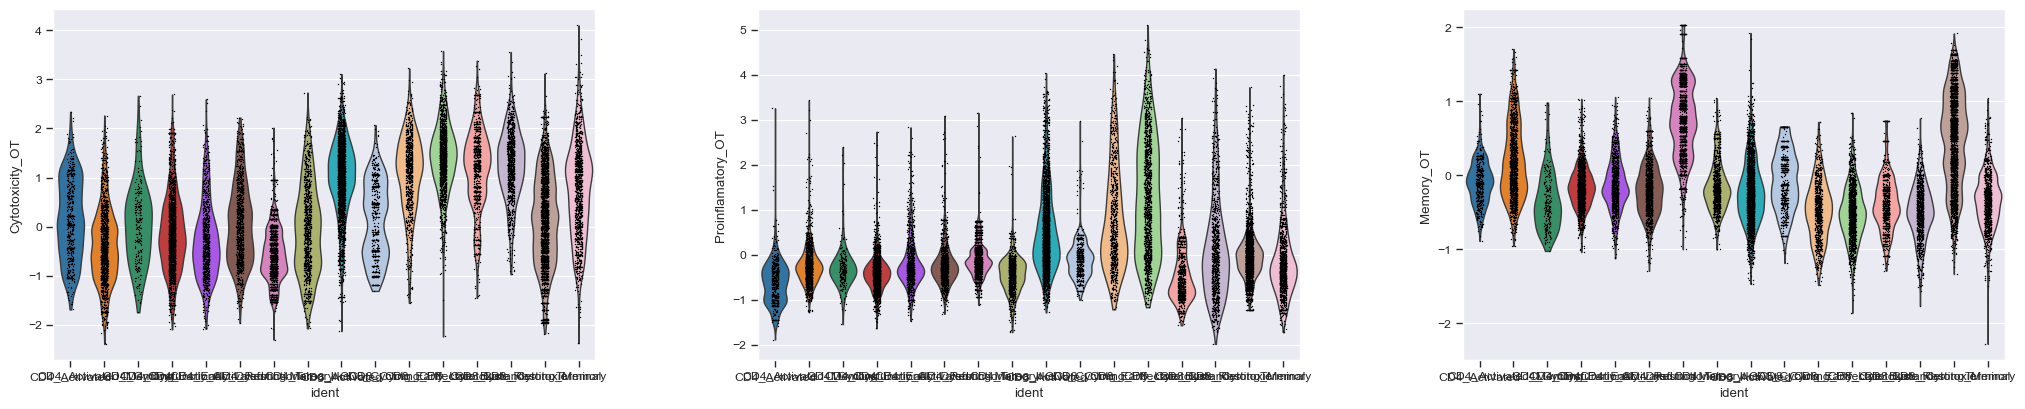

In [18]:
g = sc.pl.violin(adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflamatory_OT", "Memory_OT"])

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has b

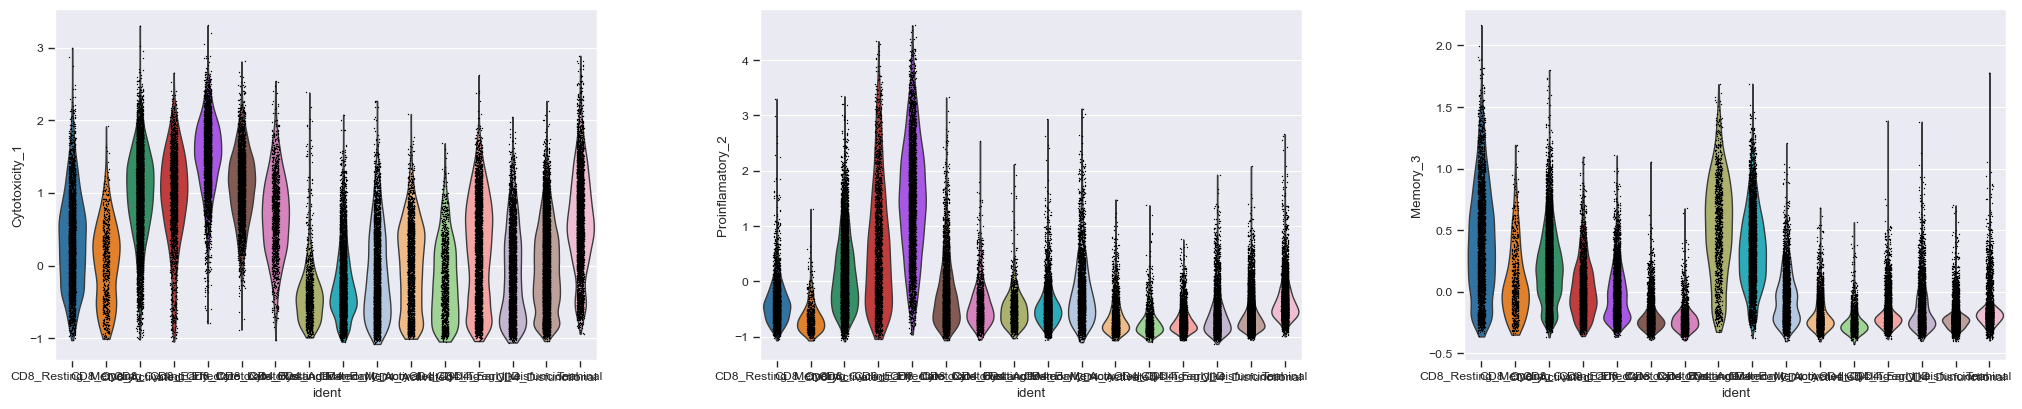

In [19]:
sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_1", "Proinflamatory_2", "Memory_3"])

# Plot percentage pos

In [20]:
adata.obs["Cytox_pos"] = [True if s>1 else False for s in adata.obs["Cytotoxicity_OT"]]
adata.obs["Proinflam_pos"] = [True if s>1 else False for s in adata.obs["Proinflamatory_OT"]]
adata.obs["Mem_pos"] = [True if s>0 else False for s in adata.obs["Memory_OT"]]

In [21]:
adata.obs.loc[(adata.obs["subset"]=="CD4")&(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD4")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = False

adata.obs.loc[(adata.obs["subset"]=="CD8")&(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD8")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = False
adata.obs["ID"] = adata.obs["ID"].astype(bool)
adata.obs["OOD"] = ~adata.obs["ID"]

In [22]:
pos_counts = adata[adata.obs["subset"]=="CD8"].obs.groupby(["CAR_Variant", "dtype", "ID", "OOD"], observed=True).sum(numeric_only=True)[["Cytox_pos", "Proinflam_pos", "Mem_pos"]]
tot = adata.obs.groupby(["CAR_Variant", "dtype"], observed=True).size()
pos_counts["total"] = tot
pos_counts["cytox_perc"] = pos_counts["Cytox_pos"] / pos_counts["total"] * 100
pos_counts["proinf_perc"] = pos_counts["Proinflam_pos"] / pos_counts["total"] * 100
pos_counts["mem_perc"] = pos_counts["Mem_pos"] / pos_counts["total"] * 100
pos_counts = pos_counts.reset_index()
pos_counts = pos_counts[~pos_counts["CAR_Variant"].isin(["NA-NA-NA", "NA-NA-z"])]
pos_counts["CAR_Variant"] = pos_counts["CAR_Variant"].astype(str)
pos_counts["dtype"] = pos_counts["dtype"].astype(str)

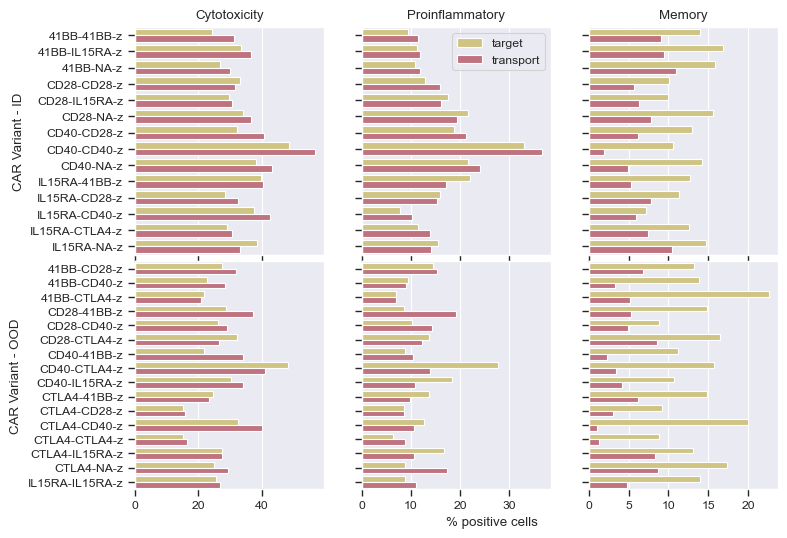

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 6), sharey='row', sharex='col')
flat_axes= axes.flat
sns.barplot(data=pos_counts[pos_counts["ID"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[0])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[1])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[2])

sns.barplot(data=pos_counts[pos_counts["OOD"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[3])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[4])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[5])


flat_axes[0].legend([],[], frameon=False)
flat_axes[2].legend([],[], frameon=False)
flat_axes[3].legend([],[], frameon=False)
flat_axes[4].legend([],[], frameon=False)
flat_axes[5].legend([],[], frameon=False)
flat_axes[1].legend(title="")

flat_axes[0].set_title("Cytotoxicity")
flat_axes[1].set_title("Proinflammatory")
flat_axes[2].set_title("Memory")

flat_axes[0].set_xlabel("")
flat_axes[1].set_xlabel("")
flat_axes[2].set_xlabel("")
flat_axes[3].set_xlabel("")
flat_axes[4].set_xlabel("")
flat_axes[5].set_xlabel("")

flat_axes[0].set_ylabel("CAR Variant - ID")
flat_axes[3].set_ylabel("CAR Variant - OOD")

fig.text(0.5, 0.05, "% positive cells")
fig.subplots_adjust(hspace=0.03)

plt.savefig(f"{base_fig_save}percentage_pos_score.pdf", bbox_inches="tight")


In [24]:
pos_counts["ID_OOD"] = ["ID" if ID else "OOD" for ID in pos_counts["ID"]]
temp = pos_counts[["CAR_Variant", "dtype", "ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]].set_index(["CAR_Variant"])
transport = temp.loc[temp["dtype"]=='transport', ["ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]]
target = temp.loc[temp["dtype"]=='target', ["cytox_perc", "proinf_perc", "mem_perc"]]
plt_data = transport.merge(target, left_index=True, right_index=True, suffixes=("_transport", "_target")).reset_index(drop=False)

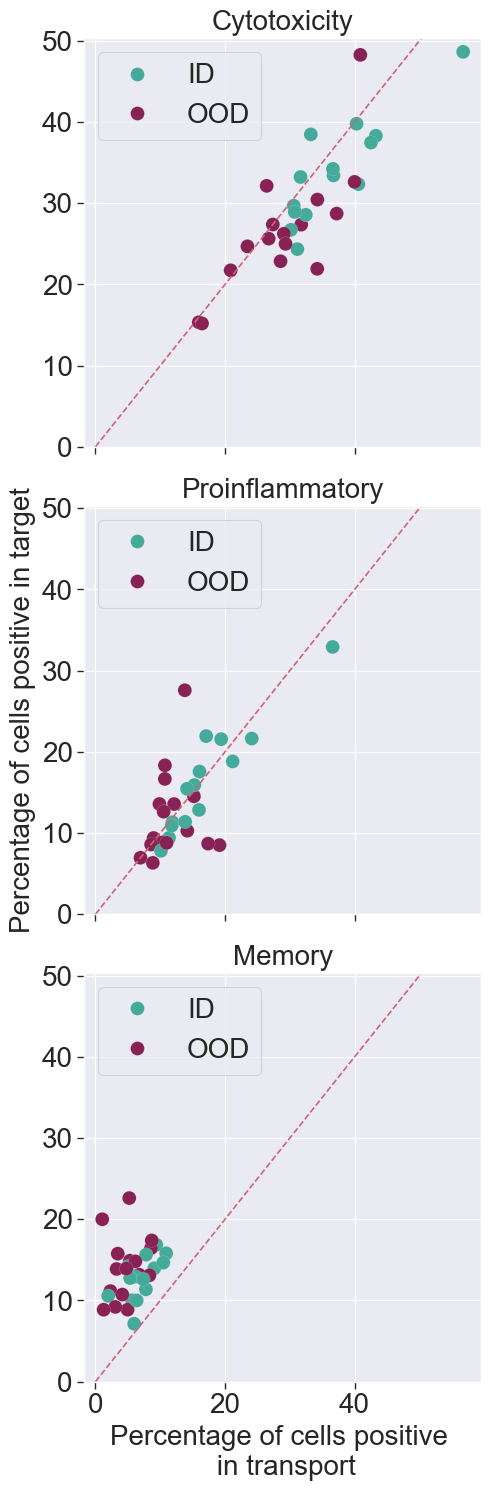

In [25]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(3, 1,sharex=True, sharey=True, figsize=(5,15))

for i, score in enumerate(scores):
    score_label = score_labels[i]

    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20)
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
fig.subplots_adjust(wspace=0.05)
axes[2].set_xlabel("Percentage of cells positive \n in transport", fontsize=20)
axes[1].set_ylabel("Percentage of cells positive in target", fontsize=20)
plt.tight_layout()
# plt.savefig(f"{base_fig_save}percentage_pos_score_scatter.pdf", bbox_inches="tight")
plt.show()


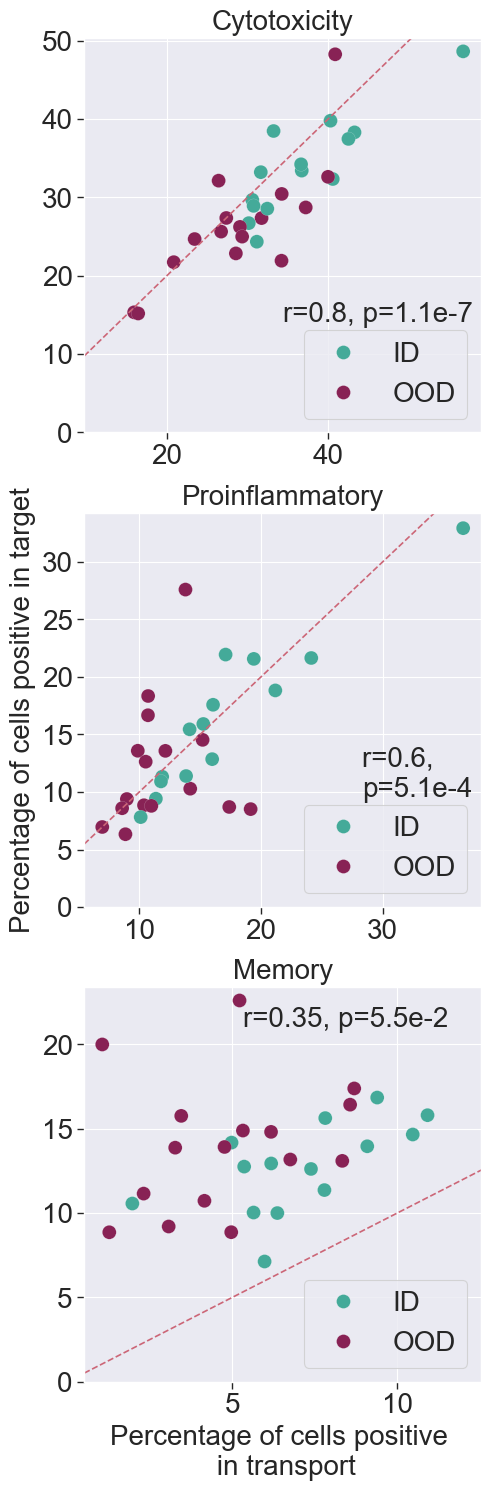

In [26]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(3, 1,sharex=False, sharey=False, figsize=(5,15))


for i, score in enumerate(scores):
    score_label = score_labels[i]
    spearman = round(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).statistic, 2)
    pval = Decimal(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).pvalue)
    pval = '{:.1e}'.format(pval)
    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20, loc="lower right")
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
    if i==0:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.5, 0.28), xycoords="axes fraction", fontsize=20)
    elif i==1:
        axes[i].annotate(f"r={spearman}, \np={pval}", xy=(0.7, 0.28), xycoords="axes fraction", fontsize=20)
    elif i==2:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.4, 0.9), xycoords="axes fraction", fontsize=20)
fig.subplots_adjust(wspace=0.05)
axes[2].set_xlabel("Percentage of cells positive \n in transport", fontsize=20)
axes[1].set_ylabel("Percentage of cells positive in target", fontsize=20)
plt.tight_layout()
plt.savefig(f"{base_fig_save}percentage_pos_score_scatter.pdf", bbox_inches="tight")
plt.show()


# Cell type distribution

In [27]:
with open(f"{classifier_path}20240229_from_rocio_for_manuscript_FuncScore_genes_svm.pkl", "rb") as f:
   celltyper = pickle.load(f)

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
adata.obs["pred_celltype"] = celltyper.predict(adata.X)
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Disfunctional", "pred_celltype"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Early_Disfuncional", "pred_celltype"] = "CD4_Early_Dysfunctional"

In [30]:
plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data1 = plt_data1.merge(plt_data1_tot, on="CAR_Variant", how="left")
plt_data1["celltype_frac"] = plt_data1["count"]/plt_data1["total"]
plt_data1 = plt_data1.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

plt_data2 = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data2_tot = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data2 = plt_data2.merge(plt_data2_tot, on="CAR_Variant", how="left")
plt_data2["celltype_frac"] = plt_data2["count"]/plt_data2["total"]
plt_data2 = plt_data2.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4", "CD8"]
anno=anno.loc[anno.index!="NA-NA-NA"]

# plt_data3 = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
# plt_data3_tot = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
# plt_data3 = plt_data3.merge(plt_data3_tot, on="CAR_Variant", how="left")
# plt_data3["celltype_frac"] = plt_data3["count"]/plt_data3["total"]
# plt_data3 = plt_data3.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_78331/2382538360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_78331/2382538360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_78331/2382538360.p

In [31]:
myColors = (default_colors['wine'], default_colors['teal'])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

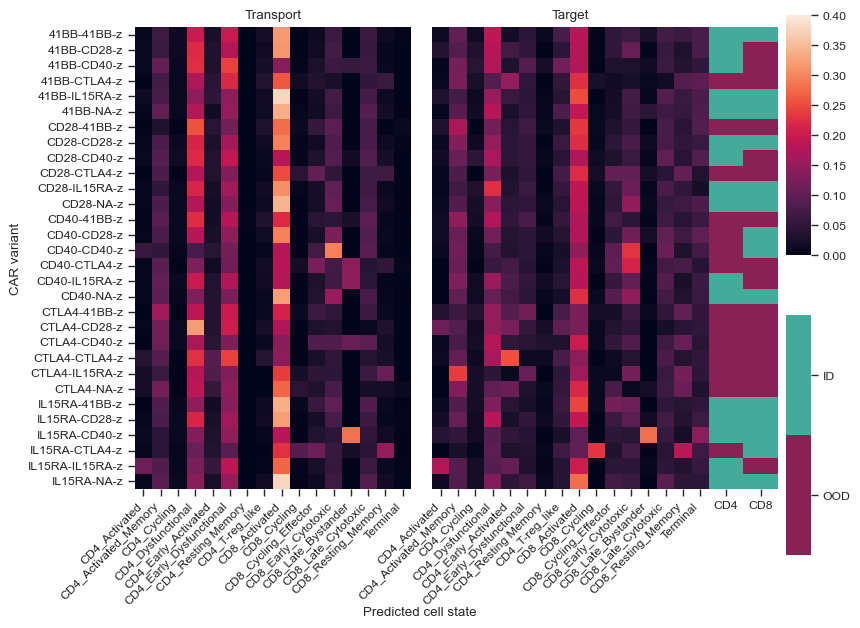

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(8.3, 6), sharey="row", sharex="col", width_ratios=[4,0.3,4,1])
cbar_ax= fig.add_axes([0.91, 0.0, 0.03, 0.4])
cbar_ax2= fig.add_axes([0.91, 0.5, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=plt_data2, ax=axes[2], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=anno, ax=axes[3], cbar_ax=cbar_ax, cmap=cmap)

axes[1].set_visible(False)

axes[0].set_title("Transport")
axes[2].set_title("Target")

axes[0].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("CAR variant")
axes[2].set_ylabel("")
axes[3].set_ylabel("")

axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right")
axes[2].set_xticks(axes[2].get_xticks(), axes[2].get_xticklabels(), rotation=45, ha="right")
axes[2].tick_params(which="both", axis="y",left=False)
axes[3].tick_params(which="both", axis="y",left=False)

cbar_ax.set_yticks([0.25, 0.75])
cbar_ax.set_yticklabels(["OOD", "ID"])

fig.text(0.4, -0.1, "Predicted cell state")
fig.subplots_adjust(wspace=0.0)
plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


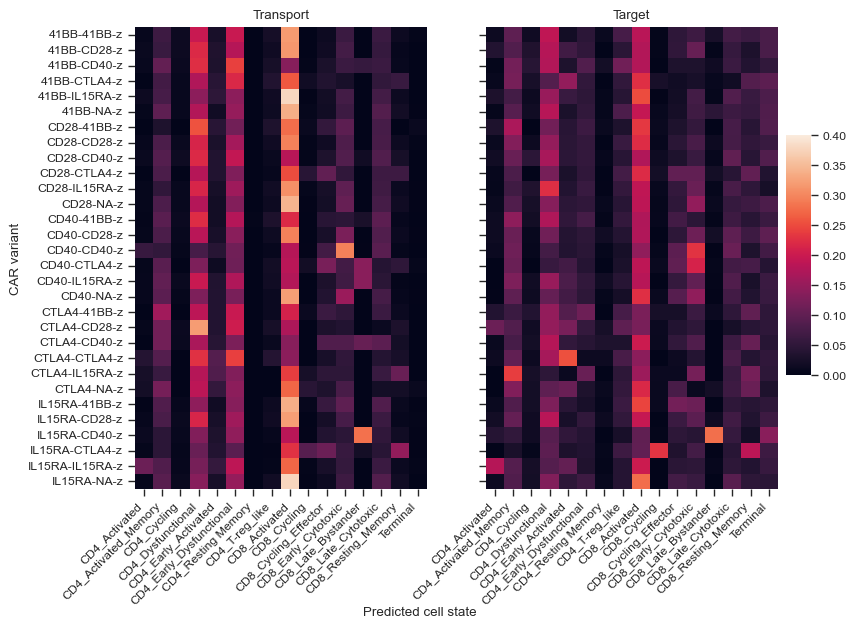

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8.3, 6), sharey="row", sharex="col")
cbar_ax= fig.add_axes([0.91, 0.3, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax)
sns.heatmap(data=plt_data2, ax=axes[1], vmin=0, vmax=0.4, cbar_ax=cbar_ax)

axes[0].set_title("Transport")
axes[1].set_title("Target")

axes[0].set_xlabel("")
axes[1].set_xlabel("")

axes[0].set_ylabel("CAR variant")
axes[1].set_ylabel("")
fig.text(0.4, -0.1, "Predicted cell state")

axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right")
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha="right")

# plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


In [34]:
anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4 - ID", "CD8 - ID"]
anno

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_78331/3763293242.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")


CD4 - ID  CD8 - ID
CAR_Variant                        
41BB-41BB-z          True      True
41BB-CD28-z          True     False
41BB-CD40-z          True     False
41BB-CTLA4-z        False     False
41BB-IL15RA-z        True      True
41BB-NA-z            True      True
CD28-41BB-z         False     False
CD28-CD28-z          True      True
CD28-CD40-z          True     False
CD28-CTLA4-z        False     False
CD28-IL15RA-z        True      True
CD28-NA-z            True      True
CD40-41BB-z         False     False
CD40-CD28-z         False      True
CD40-CD40-z         False      True
CD40-CTLA4-z        False     False
CD40-IL15RA-z        True     False
CD40-NA-z            True      True
CTLA4-41BB-z        False     False
CTLA4-CD28-z        False     False
CTLA4-CD40-z        False     False
CTLA4-CTLA4-z       False     False
CTLA4-IL15RA-z      False     False
CTLA4-NA-z          False     False
IL15RA-41BB-z        True      True
IL15RA-CD28-z        True      True
IL15RA-CD40-z        True      True
IL15RA-CTLA4-z      False      True
IL15RA-IL15RA-z      True     False
IL15RA-NA-z          True      True
NA-NA-NA            False     False